In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.contingency_tables import Table2x2
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib to display inline in Jupyter notebook
%matplotlib inline

# Set aesthetics for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
def load_data(file_path):
    """
    Load the stroke dataset and perform initial preprocessing
    """
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    # Convert binary variables to int for easier analysis
    binary_vars = ['hypertension', 'heart_disease', 'stroke']
    df[binary_vars] = df[binary_vars].astype(int)
    
    return df

In [3]:
def descriptive_statistics(df):
    """
    Generate comprehensive descriptive statistics for the dataset
    """
    print("=============================================")
    print("DESCRIPTIVE STATISTICS - STROKE DATASET")
    print("=============================================\n")
    
    # 1.1 Numerical Variables
    print("1. NUMERICAL VARIABLES")
    print("=====================\n")
    
    numerical_vars = ['age', 'avg_glucose_level', 'bmi']
    
    # Calculate basic statistics
    print("Basic Statistics:")
    stats_df = df[numerical_vars].describe().T
    # Add additional statistics
    stats_df['skew'] = df[numerical_vars].skew()
    stats_df['kurtosis'] = df[numerical_vars].kurtosis()
    stats_df['missing'] = df[numerical_vars].isnull().sum()
    stats_df['missing_pct'] = df[numerical_vars].isnull().sum() / len(df) * 100
    display(stats_df)
    print()
    
    # 1.2 Categorical Variables
    print("2. CATEGORICAL VARIABLES")
    print("=======================\n")
    
    categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                        'work_type', 'Residence_type', 'smoking_status', 'stroke']
    
    for var in categorical_vars:
        print(f"{var} distribution:")
        counts = df[var].value_counts()
        percentages = df[var].value_counts(normalize=True) * 100
        cat_stats = pd.DataFrame({
            'Count': counts,
            'Percentage (%)': percentages
        })
        display(cat_stats)
        print()
    
    # Create histograms for numerical variables
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, var in enumerate(numerical_vars):
        sns.histplot(df[var].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {var}')
    plt.tight_layout()
    plt.show()
    
    # Create countplots for categorical variables
    for var in categorical_vars:
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x=var, data=df)
        ax.set_title(f'Distribution of {var}')
        # Add count labels
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='baseline')
        plt.tight_layout()
        plt.show()
    
    return stats_df

In [4]:
def normality_tests(df):
    """
    Perform normality tests on numerical variables
    """
    numerical_vars = ['age', 'avg_glucose_level', 'bmi']
    
    print("=============================================")
    print("NORMALITY TESTS - STROKE DATASET")
    print("=============================================\n")
    
    for var in numerical_vars:
        # Skip missing values
        data = df[var].dropna()
        
        # Shapiro-Wilk test (for normality)
        shapiro_test = stats.shapiro(data)
        
        # D'Agostino's K^2 test (for normality, handles larger samples better)
        k2, p_k2 = stats.normaltest(data)
        
        print(f"Normality Tests for {var}:")
        print(f"Shapiro-Wilk Test: W={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.8f}")
        print(f"D'Agostino's K^2 Test: K2={k2:.4f}, p-value={p_k2:.8f}")
        print(f"Conclusion: {'Not normal' if p_k2 < 0.05 else 'Possibly normal'}\n")
        
        # Create Q-Q plot
        plt.figure(figsize=(10, 6))
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f'Q-Q Plot for {var}')
        plt.tight_layout()
        plt.show()

In [5]:
def correlation_analysis(df):
    """
    Perform correlation analysis between variables
    """
    # Create correlation matrix
    numerical_vars = ['age', 'avg_glucose_level', 'bmi']
    
    print("=============================================")
    print("CORRELATION ANALYSIS - STROKE DATASET")
    print("=============================================\n")
    
    # Pearson correlation
    print("Pearson Correlation (parametric):")
    pearson_corr = df[numerical_vars + ['stroke']].corr(method='pearson')
    display(pearson_corr)
    print()
    
    # Spearman correlation (non-parametric)
    print("Spearman Correlation (non-parametric):")
    spearman_corr = df[numerical_vars + ['stroke']].corr(method='spearman')
    display(spearman_corr)
    print()
    
    # Point-biserial correlation for numerical vs binary stroke
    print("Point-biserial correlation with stroke:")
    for var in numerical_vars:
        # Skip missing values
        valid_data = df[[var, 'stroke']].dropna()
        corr, pval = stats.pointbiserialr(valid_data['stroke'], valid_data[var])
        print(f"{var}: r={corr:.4f}, p-value={pval:.8f}, Significant: {pval < 0.05}")
    
    print("\nChi-square test for categorical variables vs stroke:")
    categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                       'work_type', 'Residence_type', 'smoking_status']
    
    for var in categorical_vars:
        contingency_table = pd.crosstab(df[var], df['stroke'])
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        # Calculate Cramer's V
        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        r, k = contingency_table.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        cramer_v = np.sqrt(phi2corr / min(kcorr-1, rcorr-1))
        
        print(f"{var}: Chi2={chi2:.4f}, p-value={p:.8f}, Cramer's V={cramer_v:.4f}, Significant: {p < 0.05}")
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pearson_corr, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
    plt.title('Pearson Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Create heatmap focused on stroke correlations
    plt.figure(figsize=(12, 4))
    stroke_corr = pearson_corr['stroke'].drop('stroke').sort_values(ascending=False)
    sns.heatmap(stroke_corr.to_frame().T, annot=True, cmap='viridis', fmt='.3f', linewidths=0.5)
    plt.title('Correlation with Stroke')
    plt.tight_layout()
    plt.show()

In [6]:
def hypothesis_testing(df):
    """
    Perform hypothesis tests to compare groups and detect significant differences
    """
    print("=============================================")
    print("HYPOTHESIS TESTING - STROKE DATASET")
    print("=============================================\n")
    
    numerical_vars = ['age', 'avg_glucose_level', 'bmi']
    
    # Mann-Whitney U Test (non-parametric alternative to t-test)
    print("1. Mann-Whitney U Test (comparing stroke=0 vs stroke=1):")
    print("=====================================================\n")
    
    for var in numerical_vars:
        # Get values for each stroke group
        stroke_0 = df[df['stroke'] == 0][var].dropna()
        stroke_1 = df[df['stroke'] == 1][var].dropna()
        
        # Perform Mann-Whitney U test
        u_stat, p_value = stats.mannwhitneyu(stroke_0, stroke_1, alternative='two-sided')
        
        # Add effect size calculation (common language effect size)
        effect_size = u_stat / (len(stroke_0) * len(stroke_1))
        
        print(f"{var}:")
        print(f"  No Stroke (n={len(stroke_0)}): median={stroke_0.median():.2f}, mean={stroke_0.mean():.2f}")
        print(f"  Stroke (n={len(stroke_1)}): median={stroke_1.median():.2f}, mean={stroke_1.mean():.2f}")
        print(f"  Mann-Whitney U={u_stat:.2f}, p-value={p_value:.8f}")
        print(f"  Effect size={effect_size:.4f}")
        print(f"  Significant difference: {p_value < 0.05}\n")
        
        # Create boxplot to visualize the difference
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='stroke', y=var, data=df)
        plt.title(f'{var} by Stroke Status (p={p_value:.8f})')
        plt.xlabel('Stroke')
        plt.ylabel(var)
        plt.xticks([0, 1], ['No Stroke', 'Stroke'])
        plt.tight_layout()
        plt.show()

In [7]:
def risk_analysis(df):
    """
    Perform comprehensive risk analysis including risk ratios and odds ratios
    """
    print("=============================================")
    print("RISK ANALYSIS - STROKE DATASET")
    print("=============================================\n")
    
    # 1. Age Group Risk Analysis
    print("1. Age Group Risk Analysis")
    print("=========================\n")
    
    # Create age groups
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 40, 60, float('inf')],
                            labels=['<40', '40-60', '>60'])
    
    # Calculate risk by age group
    age_risk = df.groupby('age_group')['stroke'].mean()
    age_counts = df.groupby('age_group')['stroke'].count()
    age_stroke_counts = df.groupby('age_group')['stroke'].sum()
    
    print("Risk by Age Group:")
    for group in age_risk.index:
        print(f"{group}: {age_risk[group]*100:.2f}% ({age_stroke_counts[group]} strokes out of {age_counts[group]} patients)")
    
    # Calculate risk ratios (using the youngest age group as reference)
    reference_group = '<40'
    reference_risk = age_risk[reference_group]
    
    print("\nRisk Ratios (reference: age <40):")
    for group in age_risk.index:
        risk_ratio = age_risk[group] / reference_risk
        print(f"{group}: {risk_ratio:.2f}x")
    
    # Create bar chart of age risks
    plt.figure(figsize=(10, 6))
    ax = age_risk.plot(kind='bar', color='skyblue')
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Age Group')
    # Add risk labels
    for i, v in enumerate(age_risk):
        ax.text(i, v + 0.005, f'{v*100:.2f}%', ha='center')
    plt.tight_layout()
    plt.show()
    
    # 2. Medical Conditions Risk Analysis
    print("\n2. Medical Conditions Risk Analysis")
    print("================================\n")
    
    medical_conditions = ['hypertension', 'heart_disease']
    
    for condition in medical_conditions:
        # Calculate risk by condition
        condition_risk = df.groupby(condition)['stroke'].mean()
        condition_counts = df.groupby(condition)['stroke'].count()
        condition_stroke_counts = df.groupby(condition)['stroke'].sum()
        
        print(f"{condition.capitalize()} Status and Stroke Risk:")
        for status in condition_risk.index:
            status_label = "Present" if status == 1 else "Absent"
            print(f"{status_label}: {condition_risk[status]*100:.2f}% ({condition_stroke_counts[status]} strokes out of {condition_counts[status]} patients)")
        
        # Calculate risk ratio and odds ratio
        risk_ratio = condition_risk[1] / condition_risk[0]
        
        # Construct 2x2 table for odds ratio calculation
        table = Table2x2(df.pivot_table(
            values='id', 
            index=condition, 
            columns='stroke',
            aggfunc='count'
        ).fillna(0).astype(int))
        
        odds_ratio = table.oddsratio
        odds_ratio_ci = table.oddsratio_confint()
        
        print(f"\nRisk Ratio: {risk_ratio:.2f}")
        print(f"Odds Ratio: {odds_ratio:.2f} (95% CI: {odds_ratio_ci[0]:.2f}-{odds_ratio_ci[1]:.2f})\n")
        
        # Create bar chart of condition risks
        plt.figure(figsize=(10, 6))
        ax = condition_risk.plot(kind='bar', color=['lightblue', 'salmon'])
        ax.set_ylabel('Stroke Risk')
        ax.set_title(f'Stroke Risk by {condition.capitalize()} Status')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Absent', 'Present'])
        # Add risk labels
        for i, v in enumerate(condition_risk):
            ax.text(i, v + 0.005, f'{v*100:.2f}%', ha='center')
        plt.tight_layout()
        plt.show()
    
    # 3. Glucose Level Risk Analysis
    print("\n3. Glucose Level Risk Analysis")
    print("============================\n")
    
    # Create glucose level categories based on medical standards
    df['glucose_category'] = pd.cut(df['avg_glucose_level'], 
                                  bins=[0, 100, 126, float('inf')],
                                  labels=['Normal (<100)', 'Pre-diabetic (100-125)', 'Diabetic (≥126)'])
    
    # Calculate risk by glucose category
    glucose_risk = df.groupby('glucose_category')['stroke'].mean()
    glucose_counts = df.groupby('glucose_category')['stroke'].count()
    glucose_stroke_counts = df.groupby('glucose_category')['stroke'].sum()
    
    print("Risk by Glucose Level Category:")
    for category in glucose_risk.index:
        print(f"{category}: {glucose_risk[category]*100:.2f}% ({glucose_stroke_counts[category]} strokes out of {glucose_counts[category]} patients)")
    
    # Calculate risk ratios (using normal glucose as reference)
    reference_category = 'Normal (<100)'
    reference_risk = glucose_risk[reference_category]
    
    print("\nRisk Ratios (reference: Normal glucose):")
    for category in glucose_risk.index:
        risk_ratio = glucose_risk[category] / reference_risk
        print(f"{category}: {risk_ratio:.2f}x")
    
    # Create bar chart of glucose risks
    plt.figure(figsize=(12, 6))
    ax = glucose_risk.plot(kind='bar', color='lightgreen')
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Glucose Level Category')
    # Add risk labels
    for i, v in enumerate(glucose_risk):
        ax.text(i, v + 0.005, f'{v*100:.2f}%', ha='center')
    plt.tight_layout()
    plt.show()
    
    # 4. BMI Risk Analysis
    print("\n4. BMI Risk Analysis")
    print("==================\n")
    
    # Create BMI categories based on WHO standards
    df['bmi_category'] = pd.cut(df['bmi'], 
                               bins=[0, 18.5, 25, 30, float('inf')],
                               labels=['Underweight (<18.5)', 'Normal (18.5-24.9)', 
                                       'Overweight (25-29.9)', 'Obese (≥30)'])
    
    # Calculate risk by BMI category
    bmi_risk = df.groupby('bmi_category')['stroke'].mean()
    bmi_counts = df.groupby('bmi_category')['stroke'].count()
    bmi_stroke_counts = df.groupby('bmi_category')['stroke'].sum()
    
    print("Risk by BMI Category:")
    for category in bmi_risk.index:
        if pd.notna(category):  # Skip NaN categories
            print(f"{category}: {bmi_risk[category]*100:.2f}% ({bmi_stroke_counts[category]} strokes out of {bmi_counts[category]} patients)")
    
    # Create bar chart of BMI risks
    plt.figure(figsize=(12, 6))
    ax = bmi_risk.plot(kind='bar', color='orchid')
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by BMI Category')
    # Add risk labels
    for i, v in enumerate(bmi_risk):
        if not pd.isna(v):  # Skip NaN values
            ax.text(i, v + 0.005, f'{v*100:.2f}%', ha='center')
    plt.tight_layout()
    plt.show()
    
    # Return the modified dataframe with added categories
    return df

In [8]:
def interaction_analysis(df):
    """
    Analyze interaction effects between key risk factors
    """
    print("=============================================")
    print("INTERACTION ANALYSIS - STROKE DATASET")
    print("=============================================\n")
    
    # 1. Age and hypertension interaction
    print("1. Age and Hypertension Interaction")
    print("================================\n")
    
    # Create a pivot table
    age_hyp_pivot = df.pivot_table(
        values='stroke',
        index='age_group',
        columns='hypertension',
        aggfunc='mean'
    )
    
    # Add risk ratios
    age_hyp_risk_ratio = age_hyp_pivot[1] / age_hyp_pivot[0]
    
    print("Stroke Risk by Age Group and Hypertension Status:")
    display(age_hyp_pivot)
    print("\nRisk Ratios (Hypertension vs No Hypertension):")
    display(age_hyp_risk_ratio)
    
    # Create grouped bar chart
    plt.figure(figsize=(12, 6))
    ax = age_hyp_pivot.plot(kind='bar', color=['lightblue', 'salmon'])
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Age Group and Hypertension Status')
    ax.set_xlabel('Age Group')
    ax.legend(['No Hypertension', 'Hypertension'])
    plt.tight_layout()
    plt.show()
    
    # 2. Age and heart disease interaction
    print("\n2. Age and Heart Disease Interaction")
    print("================================\n")
    
    # Create a pivot table
    age_hd_pivot = df.pivot_table(
        values='stroke',
        index='age_group',
        columns='heart_disease',
        aggfunc='mean'
    )
    
    # Add risk ratios
    age_hd_risk_ratio = age_hd_pivot[1] / age_hd_pivot[0]
    
    print("Stroke Risk by Age Group and Heart Disease Status:")
    display(age_hd_pivot)
    print("\nRisk Ratios (Heart Disease vs No Heart Disease):")
    display(age_hd_risk_ratio)
    
    # Create grouped bar chart
    plt.figure(figsize=(12, 6))
    ax = age_hd_pivot.plot(kind='bar', color=['lightblue', 'salmon'])
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Age Group and Heart Disease Status')
    ax.set_xlabel('Age Group')
    ax.legend(['No Heart Disease', 'Heart Disease'])
    plt.tight_layout()
    plt.show()
    
    # 3. Age and glucose level interaction
    print("\n3. Age and Glucose Level Interaction")
    print("================================\n")
    
    # Create a pivot table
    age_glucose_pivot = df.pivot_table(
        values='stroke',
        index='age_group',
        columns='glucose_category',
        aggfunc='mean'
    )
    
    print("Stroke Risk by Age Group and Glucose Category:")
    display(age_glucose_pivot)
    
    # Create grouped bar chart
    plt.figure(figsize=(14, 7))
    ax = age_glucose_pivot.plot(kind='bar', colormap='viridis')
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Age Group and Glucose Category')
    ax.set_xlabel('Age Group')
    plt.tight_layout()
    plt.show()
    
    # 4. Medical conditions combined effect
    print("\n4. Combined Effect of Hypertension and Heart Disease")
    print("==============================================\n")
    
    # Create a combined risk factor
    df['combined_conditions'] = df['hypertension'] + df['heart_disease']
    df['risk_category'] = df['combined_conditions'].map({
        0: 'No Conditions',
        1: 'One Condition',
        2: 'Both Conditions'
    })
    
    # Create a pivot table
    combined_risk_pivot = df.pivot_table(
        values='stroke',
        index='age_group',
        columns='risk_category',
        aggfunc='mean'
    )
    
    print("Stroke Risk by Age Group and Combined Medical Conditions:")
    display(combined_risk_pivot)
    
    # Create grouped bar chart
    plt.figure(figsize=(14, 7))
    ax = combined_risk_pivot.plot(kind='bar', colormap='viridis')
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Age Group and Combined Medical Conditions')
    ax.set_xlabel('Age Group')
    plt.tight_layout()
    plt.show()
    
    # 5. ANOVA to test interaction effects
    print("\n5. Statistical Test for Interaction Effects")
    print("=====================================\n")
    
    # Age and hypertension interaction
    formula = 'stroke ~ C(age_group) + C(hypertension) + C(age_group):C(hypertension)'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("ANOVA for Age and Hypertension Interaction:")
    display(anova_table)
    
    # Age and heart disease interaction
    formula = 'stroke ~ C(age_group) + C(heart_disease) + C(age_group):C(heart_disease)'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("\nANOVA for Age and Heart Disease Interaction:")
    display(anova_table)

In [9]:
def missing_data_analysis(df):
    """
    Analyze missing data patterns and evaluate imputation strategies
    """
    print("=============================================")
    print("MISSING DATA ANALYSIS - STROKE DATASET")
    print("=============================================\n")
    
    # Calculate missing values
    missing_counts = df.isnull().sum()
    missing_percent = df.isnull().sum() / len(df) * 100
    
    missing_df = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percent': missing_percent
    })
    
    print("Missing Values Summary:")
    display(missing_df)
    
    # Focus on BMI (likely the only variable with substantial missing values)
    if missing_counts['bmi'] > 0:
        print("\nAnalysis of BMI Missing Values:")
        
        # Create a missing indicator
        df['bmi_missing'] = df['bmi'].isnull().astype(int)
        
        # Compare stroke rates between records with and without BMI
        bmi_stroke_pivot = df.pivot_table(
            values='stroke',
            index='bmi_missing',
            aggfunc='mean'
        )
        
        print("\nStroke Rates by BMI Missingness:")
        display(bmi_stroke_pivot)
        
        # Compare age distributions between records with and without BMI
        bmi_present = df[df['bmi_missing'] == 0]['age']
        bmi_missing = df[df['bmi_missing'] == 1]['age']
        
        bmi_age_stats = pd.DataFrame({
            'BMI Present': [bmi_present.mean(), bmi_present.median()],
            'BMI Missing': [bmi_missing.mean(), bmi_missing.median()]
        }, index=['Mean Age', 'Median Age'])
        
        print("\nAge Statistics by BMI Missingness:")
        display(bmi_age_stats)
        
        # Perform t-test to check if age differs significantly
        t_stat, p_val = stats.ttest_ind(bmi_present.dropna(), bmi_missing.dropna(), equal_var=False)
        
        print(f"\nT-test for Age Difference: t={t_stat:.4f}, p-value={p_val:.8f}")
        print(f"Conclusion: {'Significant difference' if p_val < 0.05 else 'No significant difference'} in age between records with and without BMI\n")
        
        # Check relationship between age and BMI missingness
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='bmi_missing', y='age', data=df)
        plt.title('Age Distribution by BMI Missingness')
        plt.xlabel('BMI Missing')
        plt.xticks([0, 1], ['BMI Present', 'BMI Missing'])
        plt.ylabel('Age')
        plt.tight_layout()
        plt.show()
        
        # Check relationship between other variables and BMI missingness
        print("\nChi-square tests for categorical variables vs BMI missingness:")
        categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                           'work_type', 'Residence_type', 'smoking_status', 'stroke']
        
        for var in categorical_vars:
            contingency_table = pd.crosstab(df[var], df['bmi_missing'])
            chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
            
            print(f"{var}: Chi2={chi2:.4f}, p-value={p:.8f}, Significant: {p < 0.05}")
        
        # Assess potential imputation methods
        print("\nPotential BMI Imputation Methods:")
        
        # Simple imputation statistics
        bmi_mean = df['bmi'].mean()
        bmi_median = df['bmi'].median()
        
        print(f"1. Mean Imputation: {bmi_mean:.2f}")
        print(f"2. Median Imputation: {bmi_median:.2f}")
        
        # Group-based imputation
        print("\n3. Group-based Imputation (medians):")
        group_medians = df.groupby(['gender', 'age_group'])['bmi'].median().reset_index()
        display(group_medians)
        
        print("\n4. Machine Learning Imputation:")
        print("   - Recommended for this dataset due to observed patterns")
        print("   - Should include age, gender, and other relevant features as predictors")
        print("   - KNN or Random Forest imputation likely to perform well")


In [10]:
def risk_profile_analysis(df):
    """
    Create and analyze risk profiles based on combinations of risk factors
    """
    print("=============================================")
    print("RISK PROFILE ANALYSIS - STROKE DATASET")
    print("=============================================\n")
    
    # Define risk profiles
    print("Risk Profile Definitions:")
    print("1. Low Risk: Age <50, no hypertension, no heart disease")
    print("2. Moderate Risk: Age 50-70 without conditions OR Age <50 with conditions")
    print("3. High Risk: Age >70 OR Age 50-70 with conditions\n")
    
    # Create age groups optimized for risk profiling
    df['age_risk'] = pd.cut(df['age'], 
                           bins=[0, 50, 70, float('inf')],
                           labels=['<50', '50-70', '>70'])
    
    # Create risk profiles
    conditions = [
        # Low Risk
        (df['age_risk'] == '<50') & (df['hypertension'] == 0) & (df['heart_disease'] == 0),
        
        # Moderate Risk - two conditions
        ((df['age_risk'] == '50-70') & (df['hypertension'] == 0) & (df['heart_disease'] == 0)) | 
        ((df['age_risk'] == '<50') & ((df['hypertension'] == 1) | (df['heart_disease'] == 1))),
        
        # High Risk
        (df['age_risk'] == '>70') | 
        ((df['age_risk'] == '50-70') & ((df['hypertension'] == 1) | (df['heart_disease'] == 1)))
    ]
    
    choices = ['Low Risk', 'Moderate Risk', 'High Risk']
    df['risk_profile'] = np.select(conditions, choices, default='Undefined')
    
    # Calculate stroke risk by profile
    profile_risk = df.groupby('risk_profile')['stroke'].mean()
    profile_counts = df.groupby('risk_profile')['stroke'].count()
    profile_stroke_counts = df.groupby('risk_profile')['stroke'].sum()
    
    print("Risk by Profile:")
    for profile in profile_risk.index:
        print(f"{profile}: {profile_risk[profile]*100:.2f}% ({profile_stroke_counts[profile]} strokes out of {profile_counts[profile]} patients)")
    
    # Percentage of population in each risk group
    profile_percent = profile_counts / len(df) * 100
    
    print("\nPercentage of Population by Risk Profile:")
    for profile in profile_percent.index:
        print(f"{profile}: {profile_percent[profile]:.2f}%")
    
    # Calculate risk ratios (using low risk as reference)
    reference_profile = 'Low Risk'
    reference_risk = profile_risk[reference_profile]
    
    print("\nRisk Ratios (reference: Low Risk):")
    for profile in profile_risk.index:
        risk_ratio = profile_risk[profile] / reference_risk
        print(f"{profile}: {risk_ratio:.2f}x")
    
    # Create bar chart of profile risks
    plt.figure(figsize=(10, 6))
    ax = profile_risk.plot(kind='bar', color=['lightgreen', 'gold', 'salmon'])
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Risk Profile')
    # Add risk labels
    for i, v in enumerate(profile_risk):
        ax.text(i, v + 0.005, f'{v*100:.2f}%', ha='center')
    plt.tight_layout()
    plt.show()
    
    # Distribution of population by risk profile
    plt.figure(figsize=(10, 6))
    ax = profile_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'gold', 'salmon'])
    ax.set_title('Distribution of Population by Risk Profile')
    ax.set_ylabel('')  # Hide the ylabel
    plt.tight_layout()
    plt.show()

In [11]:
def smoking_work_analysis(df):
    """
    Analyze smoking status and work type as risk factors
    """
    print("=============================================")
    print("SMOKING AND WORK TYPE ANALYSIS - STROKE DATASET")
    print("=============================================\n")
    
    # 1. Smoking Status Analysis
    print("1. Smoking Status Analysis")
    print("========================\n")
    
    # Calculate risk by smoking status
    smoking_risk = df.groupby('smoking_status')['stroke'].mean()
    smoking_counts = df.groupby('smoking_status')['stroke'].count()
    smoking_stroke_counts = df.groupby('smoking_status')['stroke'].sum()
    
    print("Risk by Smoking Status:")
    for status in smoking_risk.index:
        print(f"{status}: {smoking_risk[status]*100:.2f}% ({smoking_stroke_counts[status]} strokes out of {smoking_counts[status]} patients)")
    
    # Calculate risk ratios (using 'never smoked' as reference)
    reference_status = 'never smoked'
    reference_risk = smoking_risk[reference_status]
    
    print("\nRisk Ratios (reference: never smoked):")
    for status in smoking_risk.index:
        risk_ratio = smoking_risk[status] / reference_risk
        print(f"{status}: {risk_ratio:.2f}x")
    
    # Create bar chart of smoking risks
    plt.figure(figsize=(12, 6))
    ax = smoking_risk.plot(kind='bar', color='lightblue')
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Smoking Status')
    # Add risk labels
    for i, v in enumerate(smoking_risk):
        ax.text(i, v + 0.005, f'{v*100:.2f}%', ha='center')
    plt.tight_layout()
    plt.show()
    
    # Analyze age distribution by smoking status
    smoking_age = df.groupby('smoking_status')['age'].mean()
    
    print("\nMean Age by Smoking Status:")
    display(smoking_age)
    
    # 2. Work Type Analysis
    print("\n2. Work Type Analysis")
    print("===================\n")
    
    # Calculate risk by work type
    work_risk = df.groupby('work_type')['stroke'].mean()
    work_counts = df.groupby('work_type')['stroke'].count()
    work_stroke_counts = df.groupby('work_type')['stroke'].sum()
    
    print("Risk by Work Type:")
    for work_type in work_risk.index:
        print(f"{work_type}: {work_risk[work_type]*100:.2f}% ({work_stroke_counts[work_type]} strokes out of {work_counts[work_type]} patients)")
    
    # Calculate risk ratios (using 'children' as reference, as they should have the lowest risk)
    reference_work = 'children'
    reference_risk = work_risk[reference_work]
    
    print("\nRisk Ratios (reference: children):")
    for work_type in work_risk.index:
        if work_risk[reference_work] > 0:  # Avoid division by zero
            risk_ratio = work_risk[work_type] / reference_risk
            print(f"{work_type}: {risk_ratio:.2f}x")
        else:
            print(f"{work_type}: Cannot calculate (reference risk is zero)")
    
    # Create bar chart of work type risks
    plt.figure(figsize=(12, 6))
    ax = work_risk.plot(kind='bar', color='lightgreen')
    ax.set_ylabel('Stroke Risk')
    ax.set_title('Stroke Risk by Work Type')
    # Add risk labels
    for i, v in enumerate(work_risk):
        ax.text(i, v + 0.005, f'{v*100:.2f}%', ha='center')
    plt.tight_layout()
    plt.show()
    
    # Analyze age distribution by work type
    work_age = df.groupby('work_type')['age'].mean()
    
    print("\nMean Age by Work Type:")
    display(work_age)

In [12]:
def summary_analysis(df):
    """
    Create a comprehensive summary of the key findings
    """
    print("=============================================")
    print("SUMMARY OF KEY FINDINGS - STROKE DATASET")
    print("=============================================\n")
    
    print("1. Top Risk Factors for Stroke (by Risk Ratio)")
    print("=========================================\n")
    
    # Age (>60 vs <40)
    age_risk = df.groupby('age_group')['stroke'].mean()
    age_risk_ratio = age_risk['>60'] / age_risk['<40']
    
    # Heart disease
    heart_risk = df.groupby('heart_disease')['stroke'].mean()
    heart_risk_ratio = heart_risk[1] / heart_risk[0]
    
    # Hypertension
    hyp_risk = df.groupby('hypertension')['stroke'].mean()
    hyp_risk_ratio = hyp_risk[1] / hyp_risk[0]
    
    # Glucose (diabetic vs normal)
    glucose_risk = df.groupby('glucose_category')['stroke'].mean()
    glucose_risk_ratio = glucose_risk['Diabetic (≥126)'] / glucose_risk['Normal (<100)']
    
    # Create summary table
    risk_factors = [
        {'Factor': 'Age >60 (vs <40)', 'Risk Ratio': age_risk_ratio, 'Absolute Risk': age_risk['>60']},
        {'Factor': 'Heart Disease', 'Risk Ratio': heart_risk_ratio, 'Absolute Risk': heart_risk[1]},
        {'Factor': 'Hypertension', 'Risk Ratio': hyp_risk_ratio, 'Absolute Risk': hyp_risk[1]},
        {'Factor': 'Diabetic Glucose Levels', 'Risk Ratio': glucose_risk_ratio, 'Absolute Risk': glucose_risk['Diabetic (≥126)']}
    ]
    
    # Sort by risk ratio
    risk_factors = sorted(risk_factors, key=lambda x: x['Risk Ratio'], reverse=True)
    
    # Display the risk factors
    for i, factor in enumerate(risk_factors):
        print(f"{i+1}. {factor['Factor']}")
        print(f"   Risk Ratio: {factor['Risk Ratio']:.2f}x")
        print(f"   Absolute Risk: {factor['Absolute Risk']*100:.2f}%\n")
    
    # Create risk ratio chart
    risk_ratio_df = pd.DataFrame(risk_factors)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Factor', y='Risk Ratio', data=risk_ratio_df, palette='viridis')
    ax.set_title('Risk Ratios for Major Stroke Risk Factors')
    ax.set_ylabel('Risk Ratio')
    # Add risk ratio labels
    for i, v in enumerate(risk_ratio_df['Risk Ratio']):
        ax.text(i, v + 0.5, f'{v:.2f}x', ha='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("2. Risk Profile Analysis")
    print("=====================\n")
    
    profile_risk = df.groupby('risk_profile')['stroke'].mean()
    profile_counts = df.groupby('risk_profile')['stroke'].count()
    
    print("Population Distribution and Stroke Risk by Risk Profile:")
    for profile in profile_risk.index:
        print(f"{profile}:")
        print(f"   Population: {profile_counts[profile]/len(df)*100:.2f}%")
        print(f"   Stroke Risk: {profile_risk[profile]*100:.2f}%\n")
    
    print("3. Key Interaction Effects")
    print("=======================\n")
    
    # Age and hypertension
    age_hyp_pivot = df.pivot_table(
        values='stroke',
        index='age_group',
        columns='hypertension',
        aggfunc='mean'
    )
    
    print("Age and Hypertension Interaction:")
    display(age_hyp_pivot)
    
    # Age and heart disease
    age_hd_pivot = df.pivot_table(
        values='stroke',
        index='age_group',
        columns='heart_disease',
        aggfunc='mean'
    )
    
    print("\nAge and Heart Disease Interaction:")
    display(age_hd_pivot)
    
    print("\n4. Missing Data Patterns")
    print("=====================\n")
    
    missing_counts = df.isnull().sum()
    missing_percent = df.isnull().sum() / len(df) * 100
    
    print("Variables with Missing Data:")
    for var in missing_counts.index:
        if missing_counts[var] > 0:
            print(f"{var}: {missing_counts[var]} values ({missing_percent[var]:.2f}%)")
    
    print("\n5. Recommendations for Modeling")
    print("============================\n")
    
    print("Based on the statistical analysis, the following recommendations are made for modeling:\n")
    
    print("a) Feature Engineering:")
    print("   - Create age group categories (<40, 40-60, >60) as they show non-linear risk patterns")
    print("   - Create glucose level categories (normal, pre-diabetic, diabetic)")
    print("   - Consider interaction terms between age and medical conditions")
    print("   - Create a combined risk score based on age and medical conditions\n")
    
    print("b) Missing Data Handling:")
    print("   - Use machine learning imputation for BMI, including age and gender as predictors")
    print("   - Consider MICE (Multiple Imputation by Chained Equations) or KNN imputation\n")
    
    print("c) Class Imbalance Handling:")
    print("   - Apply SMOTE or ADASYN for oversampling the minority class")
    print("   - Consider stratified sampling during cross-validation")
    print("   - Use appropriate evaluation metrics (F1-score, AUPRC) instead of accuracy\n")
    
    print("d) Model Selection:")
    print("   - Start with interpretable models (logistic regression, decision trees)")
    print("   - Progress to more complex models (Random Forest, Gradient Boosting)")
    print("   - Consider calibrated probability estimates for risk prediction\n")
    
    # Create a summary visualization
    # Top risk factors by absolute risk
    risk_factors_df = pd.DataFrame(risk_factors)
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    sns.barplot(x='Factor', y='Risk Ratio', data=risk_factors_df, palette='viridis')
    plt.title('Risk Ratios for Major Stroke Risk Factors')
    plt.ylabel('Risk Ratio')
    plt.xticks(rotation=45, ha='right')
    
    plt.subplot(2, 1, 2)
    sns.barplot(x='Factor', y='Absolute Risk', data=risk_factors_df, palette='viridis')
    plt.title('Absolute Stroke Risk for Major Risk Factors')
    plt.ylabel('Absolute Risk')
    plt.xticks(rotation=45, ha='right')
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
    
    plt.tight_layout()
    plt.show()

Dataset shape: (5110, 12)
DESCRIPTIVE STATISTICS - STROKE DATASET

1. NUMERICAL VARIABLES

Basic Statistics:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,missing,missing_pct
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00,-0.137059,-0.991010,0,0.000000
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74,1.572284,1.680479,0,0.000000
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60,1.055340,3.362659,201,3.933464



2. CATEGORICAL VARIABLES

gender distribution:


,Count,Percentage (%)
gender,,
Female,2994,58.590998
Male,2115,41.389432
Other,1,0.019569



hypertension distribution:


,Count,Percentage (%)
hypertension,,
0,4612,90.254403
1,498,9.745597



heart_disease distribution:


,Count,Percentage (%)
heart_disease,,
0,4834,94.598826
1,276,5.401174



ever_married distribution:


,Count,Percentage (%)
ever_married,,
Yes,3353,65.616438
No,1757,34.383562



work_type distribution:


,Count,Percentage (%)
work_type,,
Private,2925,57.240705
Self-employed,819,16.027397
children,687,13.444227
Govt_job,657,12.857143
Never_worked,22,0.430528



Residence_type distribution:


,Count,Percentage (%)
Residence_type,,
Urban,2596,50.802348
Rural,2514,49.197652



smoking_status distribution:


,Count,Percentage (%)
smoking_status,,
never smoked,1892,37.025440
Unknown,1544,30.215264
formerly smoked,885,17.318982
smokes,789,15.440313



stroke distribution:


,Count,Percentage (%)
stroke,,
0,4861,95.127202
1,249,4.872798


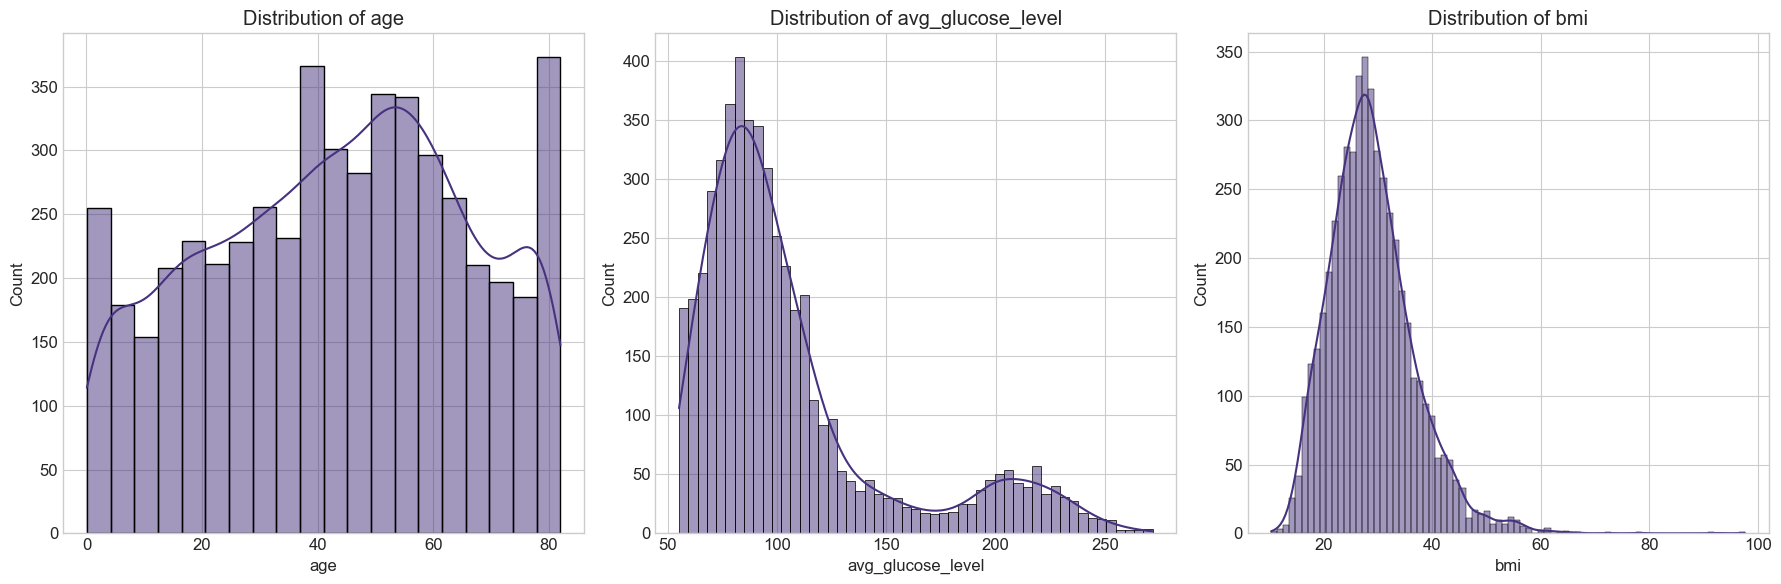

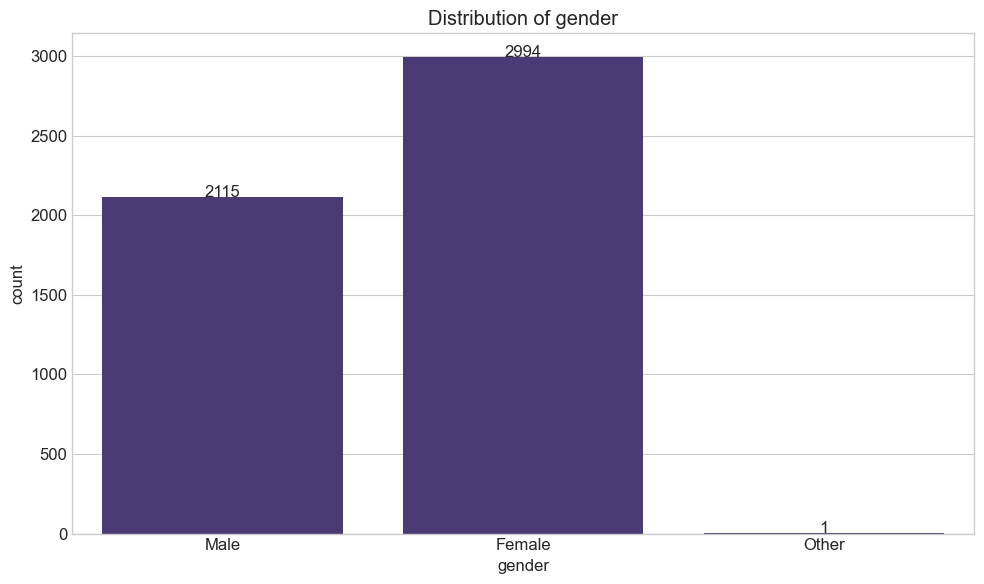

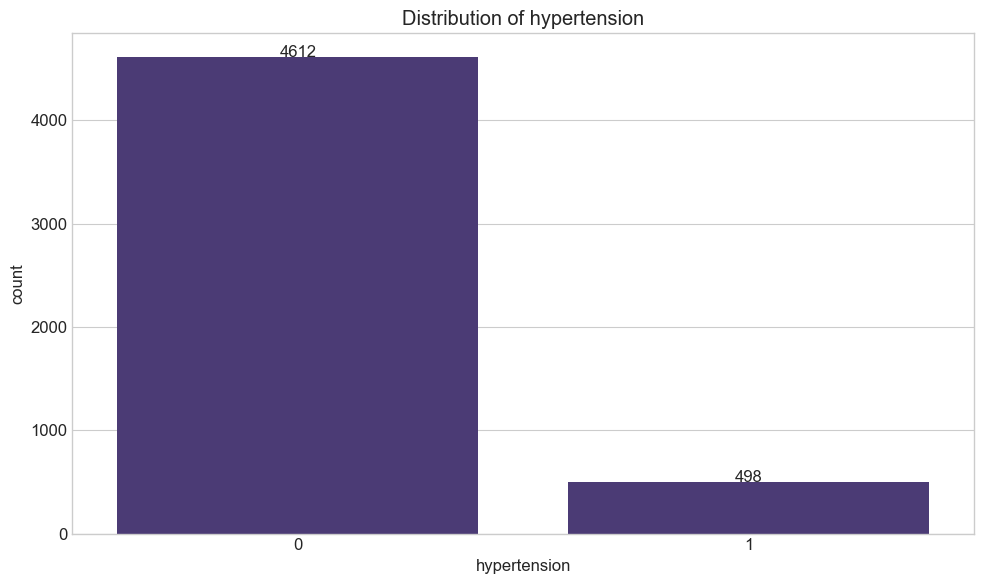

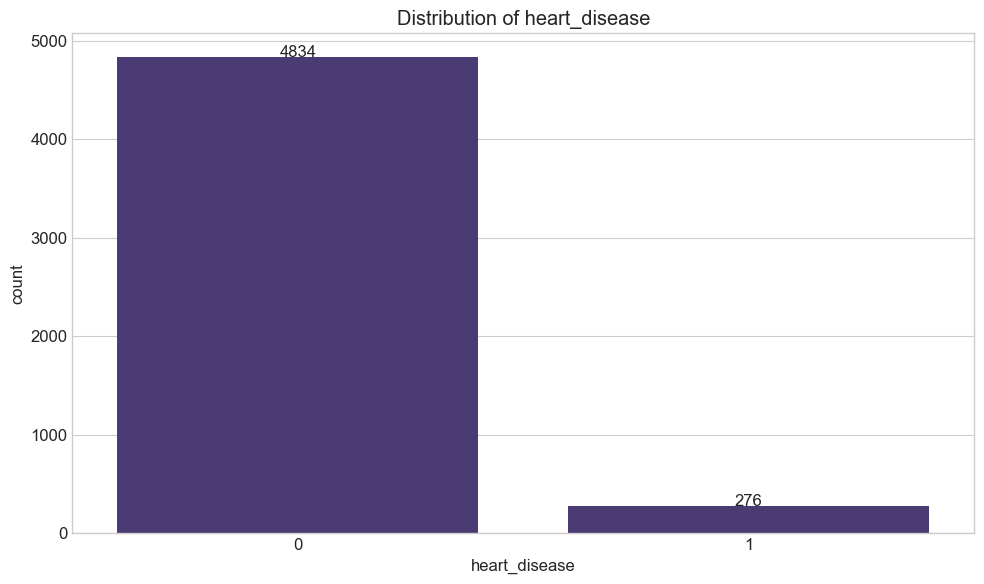

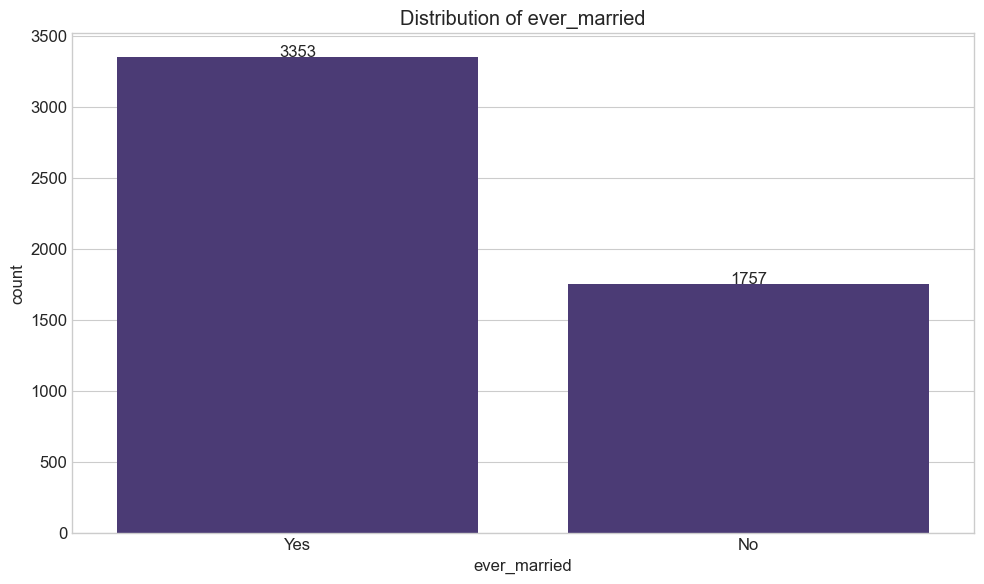

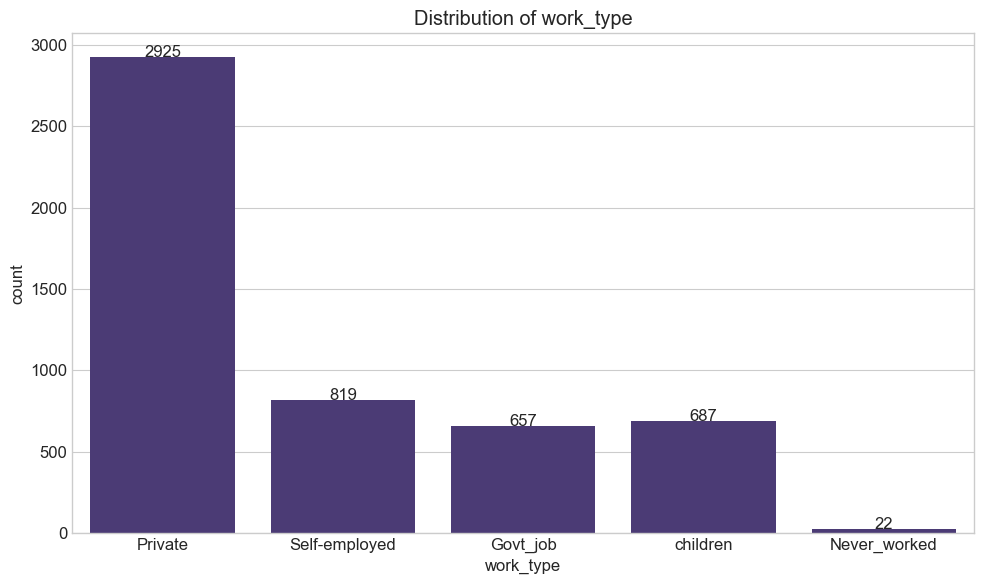

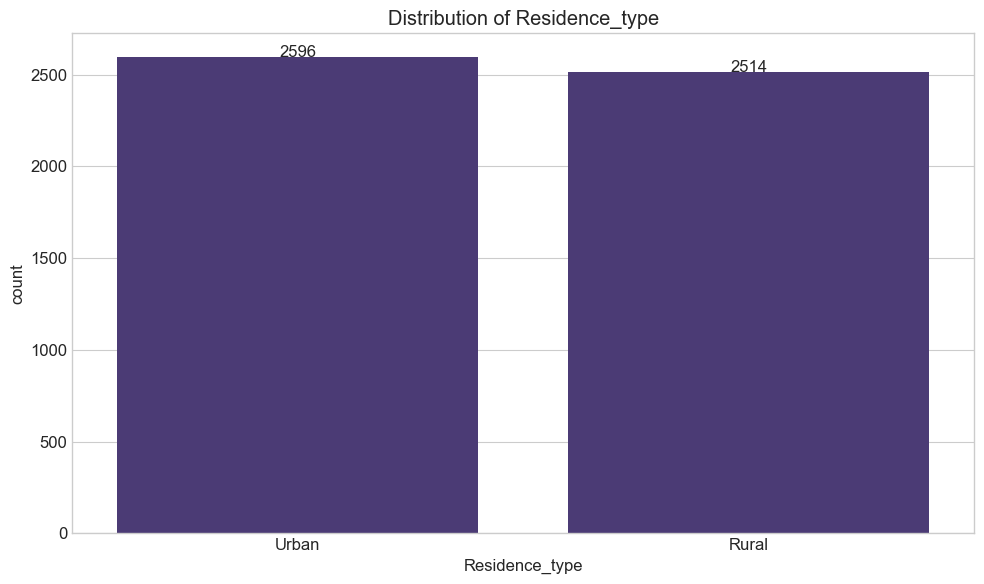

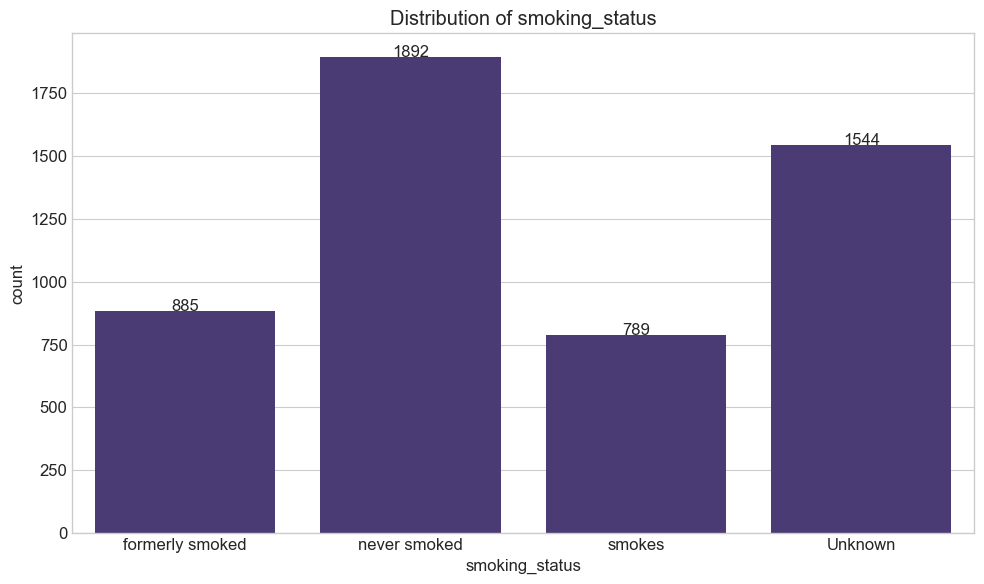

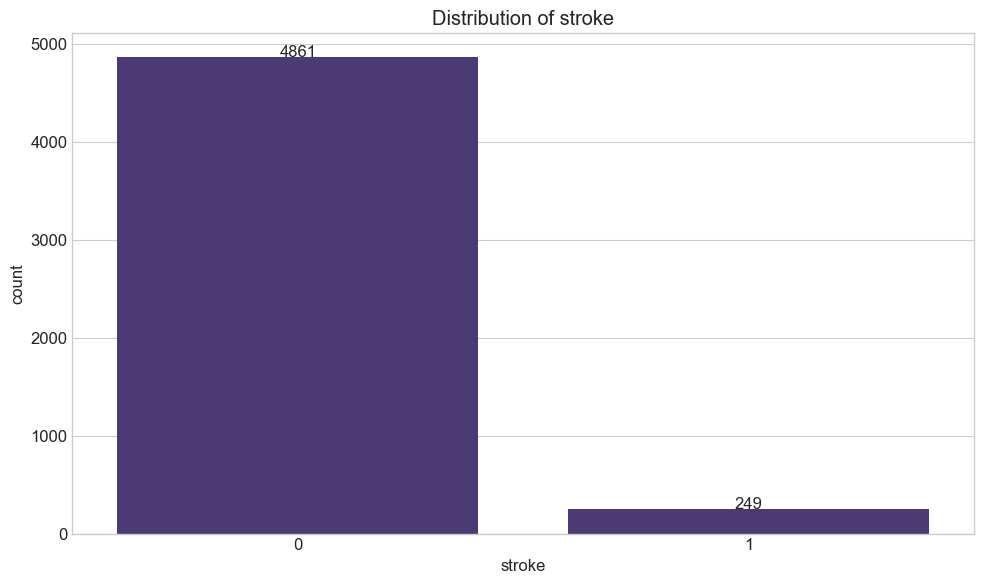

NORMALITY TESTS - STROKE DATASET

Normality Tests for age:
Shapiro-Wilk Test: W=0.9672, p-value=0.00000000
D'Agostino's K^2 Test: K2=1120.5286, p-value=0.00000000
Conclusion: Not normal



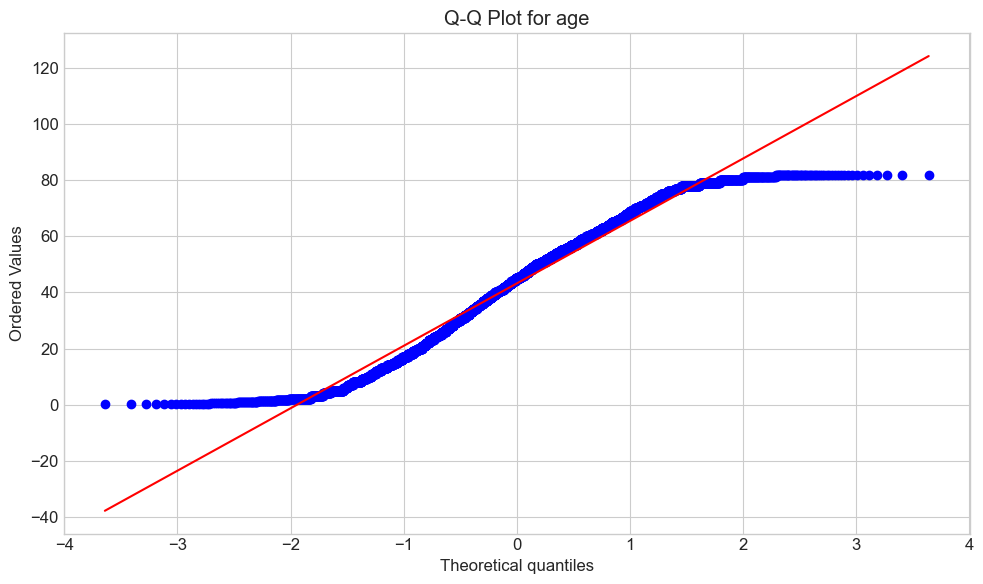

Normality Tests for avg_glucose_level:
Shapiro-Wilk Test: W=0.8059, p-value=0.00000000
D'Agostino's K^2 Test: K2=1328.9358, p-value=0.00000000
Conclusion: Not normal



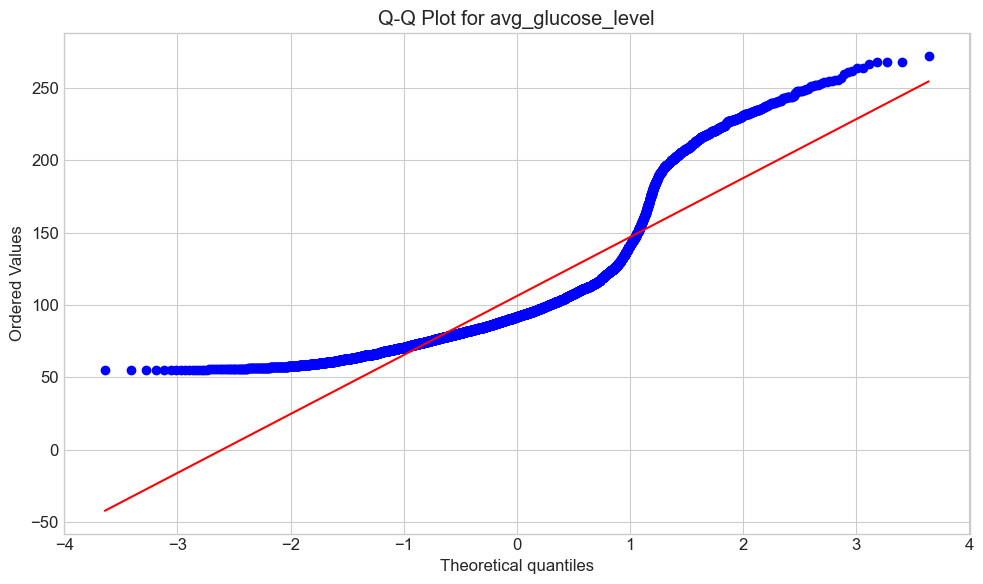

Normality Tests for bmi:
Shapiro-Wilk Test: W=0.9535, p-value=0.00000000
D'Agostino's K^2 Test: K2=1021.1795, p-value=0.00000000
Conclusion: Not normal



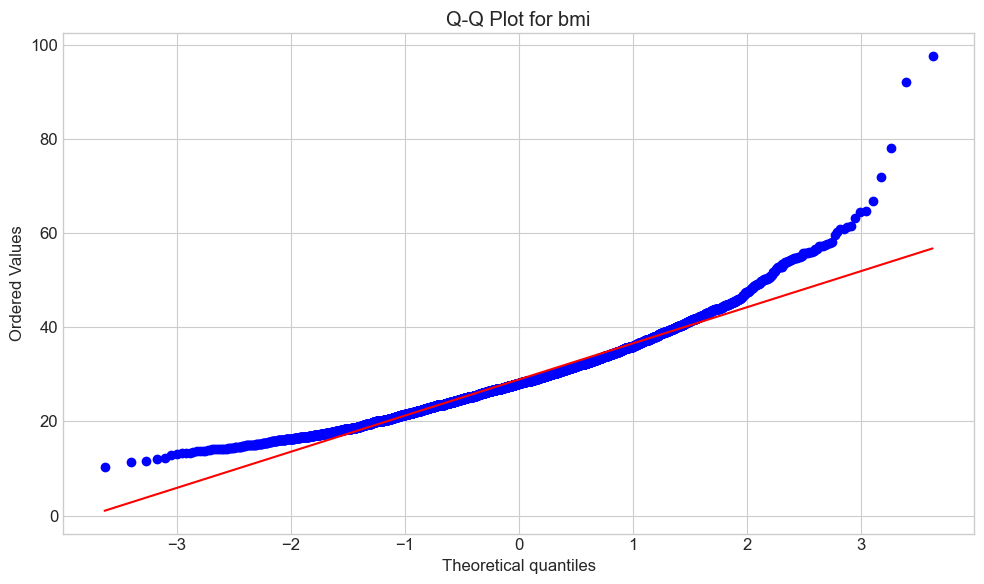

CORRELATION ANALYSIS - STROKE DATASET

Pearson Correlation (parametric):


,age,avg_glucose_level,bmi,stroke
age,1.000000,0.238171,0.333398,0.245257
avg_glucose_level,0.238171,1.000000,0.175502,0.131945
bmi,0.333398,0.175502,1.000000,0.042374
stroke,0.245257,0.131945,0.042374,1.000000



Spearman Correlation (non-parametric):


,age,avg_glucose_level,bmi,stroke
age,1.000000,0.145168,0.375650,0.249531
avg_glucose_level,0.145168,1.000000,0.114370,0.082541
bmi,0.375650,0.114370,1.000000,0.055445
stroke,0.249531,0.082541,0.055445,1.000000



Point-biserial correlation with stroke:
age: r=0.2453, p-value=0.00000000, Significant: True
avg_glucose_level: r=0.1319, p-value=0.00000000, Significant: True
bmi: r=0.0424, p-value=0.00298327, Significant: True

Chi-square test for categorical variables vs stroke:
gender: Chi2=0.4726, p-value=0.78954905, Cramer's V=0.0000, Significant: False
hypertension: Chi2=81.6054, p-value=0.00000000, Cramer's V=0.1256, Significant: True
heart_disease: Chi2=90.2596, p-value=0.00000000, Cramer's V=0.1322, Significant: True
ever_married: Chi2=58.9239, p-value=0.00000000, Cramer's V=0.1065, Significant: True
work_type: Chi2=49.1635, p-value=0.00000000, Cramer's V=0.0940, Significant: True
Residence_type: Chi2=1.0816, p-value=0.29833169, Cramer's V=0.0040, Significant: False
smoking_status: Chi2=29.1473, p-value=0.00000209, Cramer's V=0.0715, Significant: True


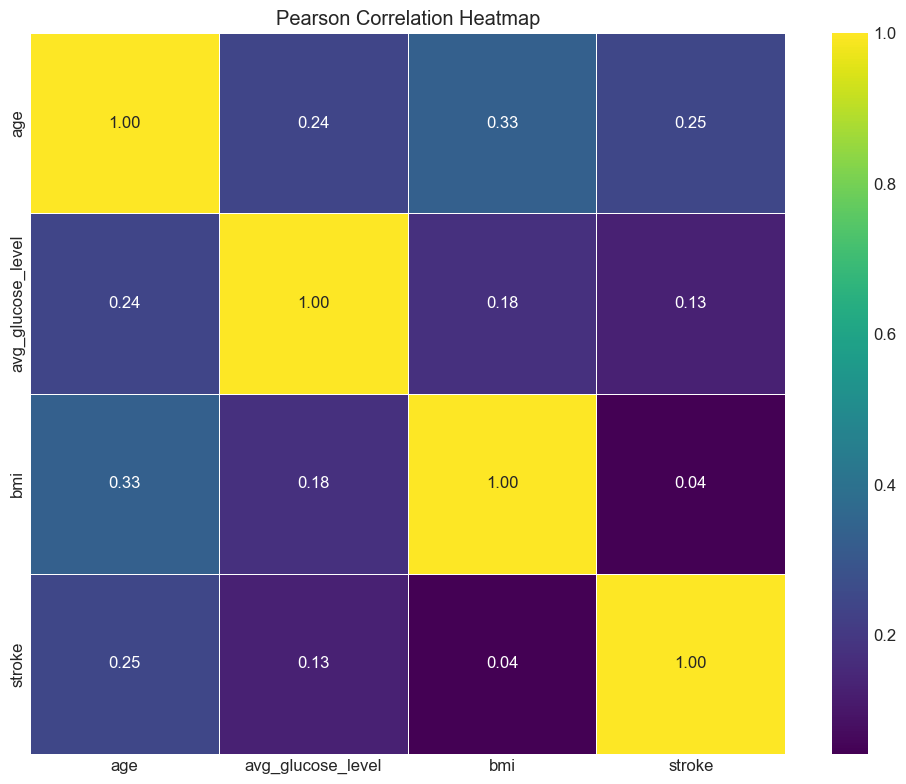

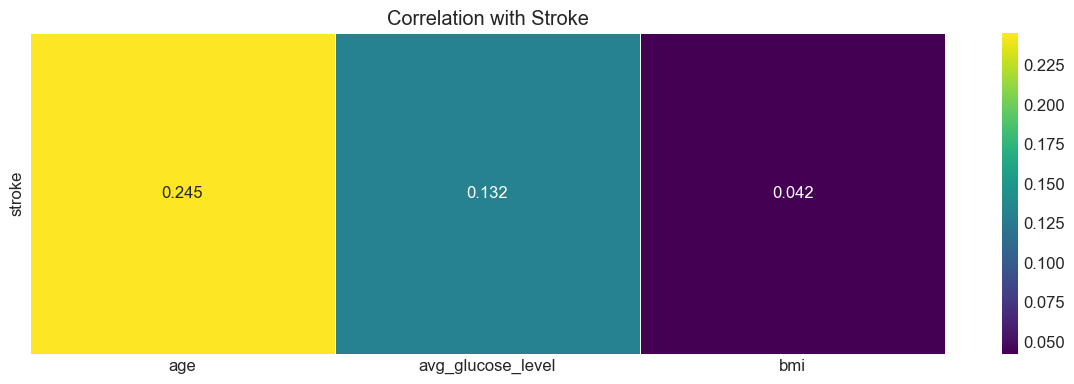

HYPOTHESIS TESTING - STROKE DATASET

1. Mann-Whitney U Test (comparing stroke=0 vs stroke=1):

age:
  No Stroke (n=4861): median=43.00, mean=41.97
  Stroke (n=249): median=71.00, mean=67.73
  Mann-Whitney U=200263.50, p-value=0.00000000
  Effect size=0.1655
  Significant difference: True



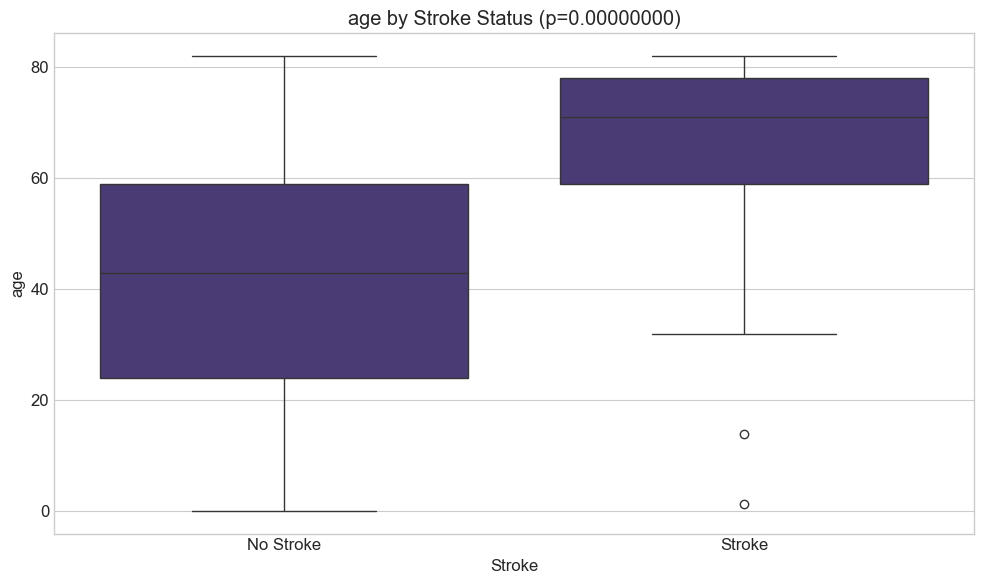

avg_glucose_level:
  No Stroke (n=4861): median=91.47, mean=104.80
  Stroke (n=249): median=105.22, mean=132.54
  Mann-Whitney U=471239.00, p-value=0.00000000
  Effect size=0.3893
  Significant difference: True



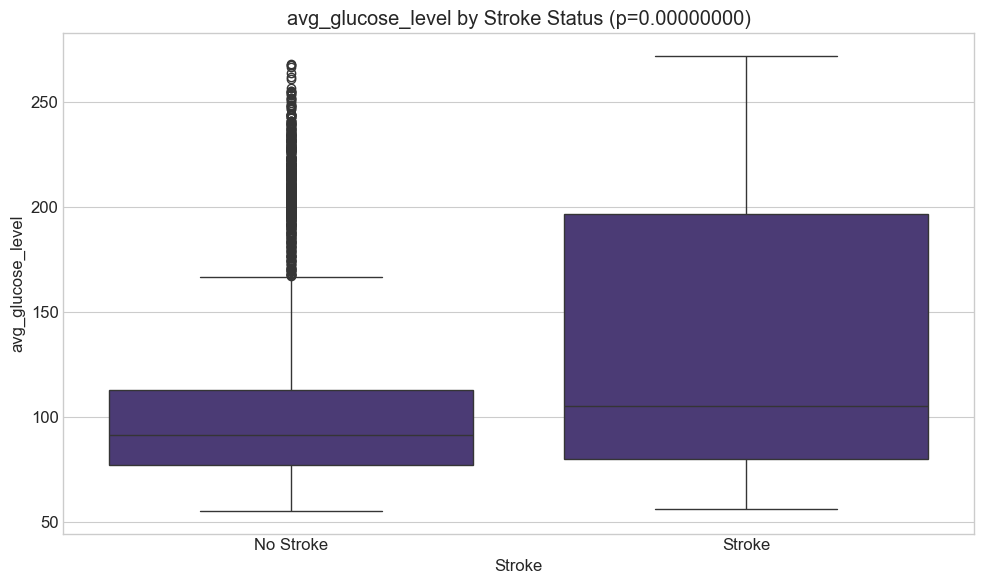

bmi:
  No Stroke (n=4700): median=28.00, mean=28.82
  Stroke (n=209): median=29.70, mean=30.47
  Mann-Whitney U=413278.50, p-value=0.00010264
  Effect size=0.4207
  Significant difference: True



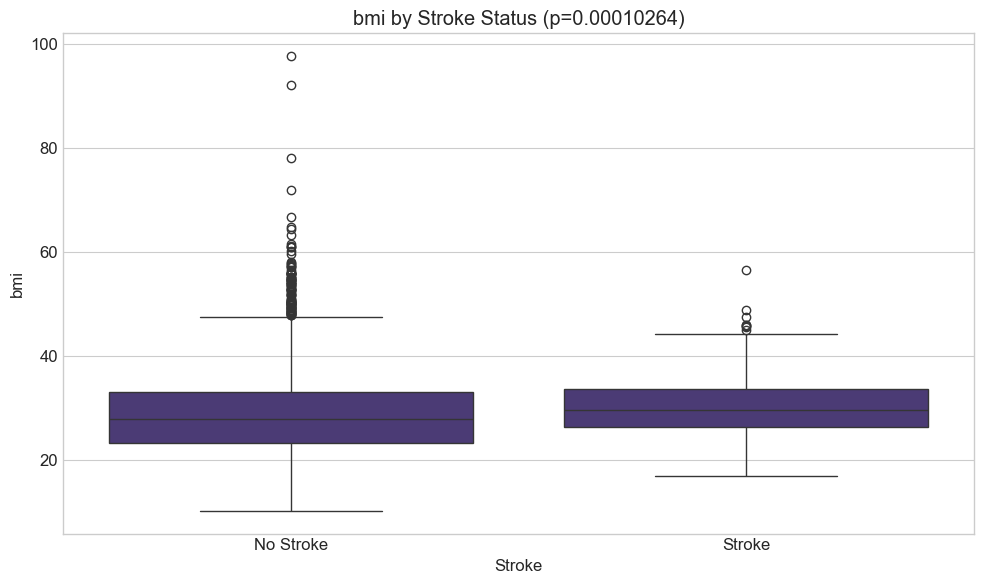

RISK ANALYSIS - STROKE DATASET

1. Age Group Risk Analysis

Risk by Age Group:
<40: 0.36% (8 strokes out of 2244 patients)
40-60: 4.10% (64 strokes out of 1562 patients)
>60: 13.57% (177 strokes out of 1304 patients)

Risk Ratios (reference: age <40):
<40: 1.00x
40-60: 11.49x
>60: 38.07x


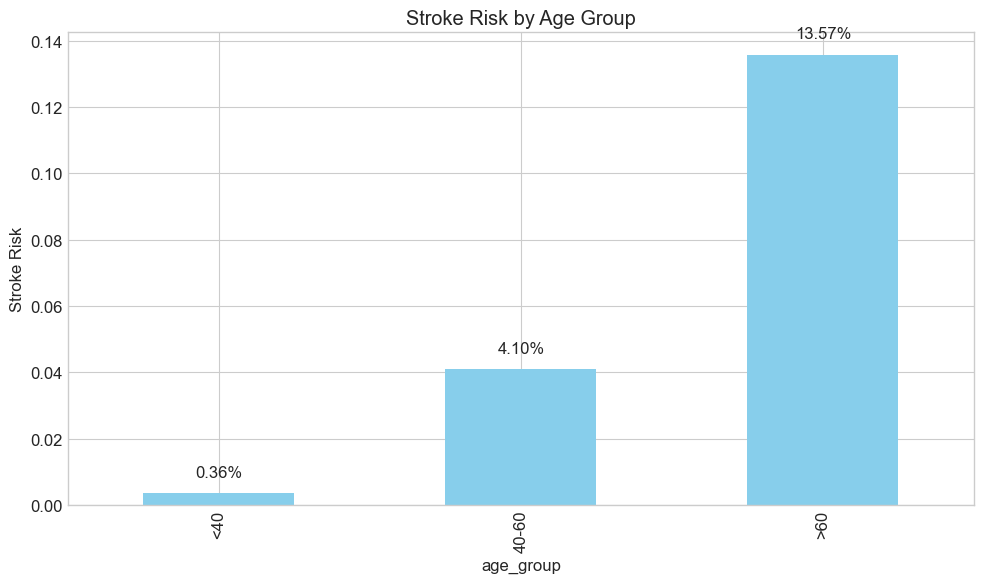


2. Medical Conditions Risk Analysis

Hypertension Status and Stroke Risk:
Absent: 3.97% (183 strokes out of 4612 patients)
Present: 13.25% (66 strokes out of 498 patients)

Risk Ratio: 3.34
Odds Ratio: 3.70 (95% CI: 2.74-4.98)



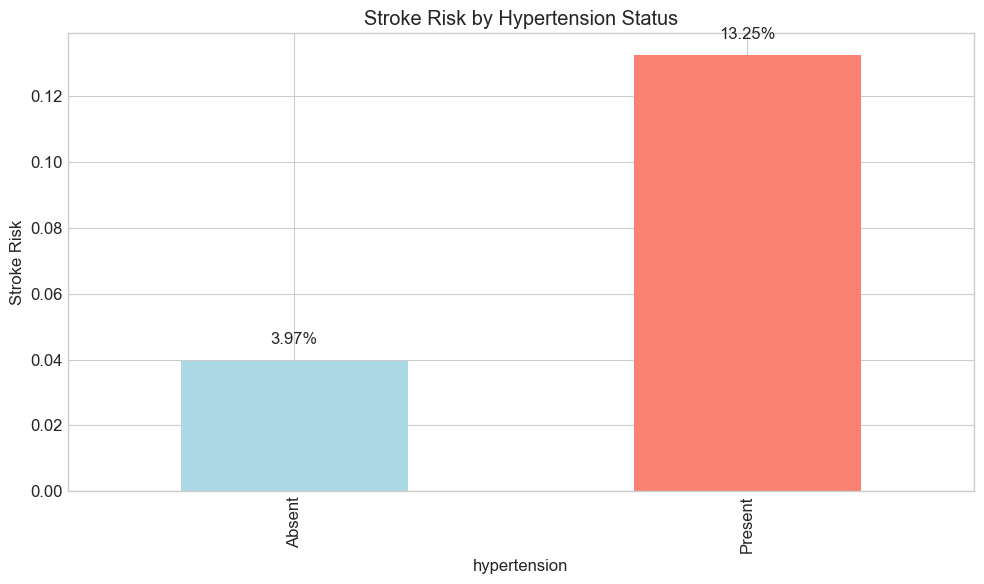

Heart_disease Status and Stroke Risk:
Absent: 4.18% (202 strokes out of 4834 patients)
Present: 17.03% (47 strokes out of 276 patients)

Risk Ratio: 4.08
Odds Ratio: 4.71 (95% CI: 3.34-6.64)



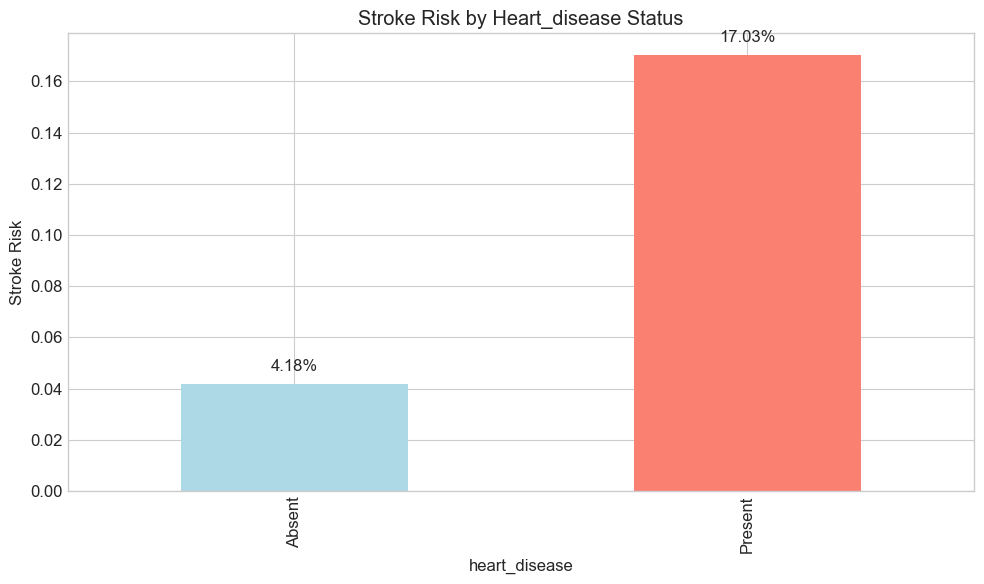


3. Glucose Level Risk Analysis

Risk by Glucose Level Category:
Normal (<100): 3.58% (112 strokes out of 3131 patients)
Pre-diabetic (100-125): 3.71% (37 strokes out of 998 patients)
Diabetic (≥126): 10.19% (100 strokes out of 981 patients)

Risk Ratios (reference: Normal glucose):
Normal (<100): 1.00x
Pre-diabetic (100-125): 1.04x
Diabetic (≥126): 2.85x


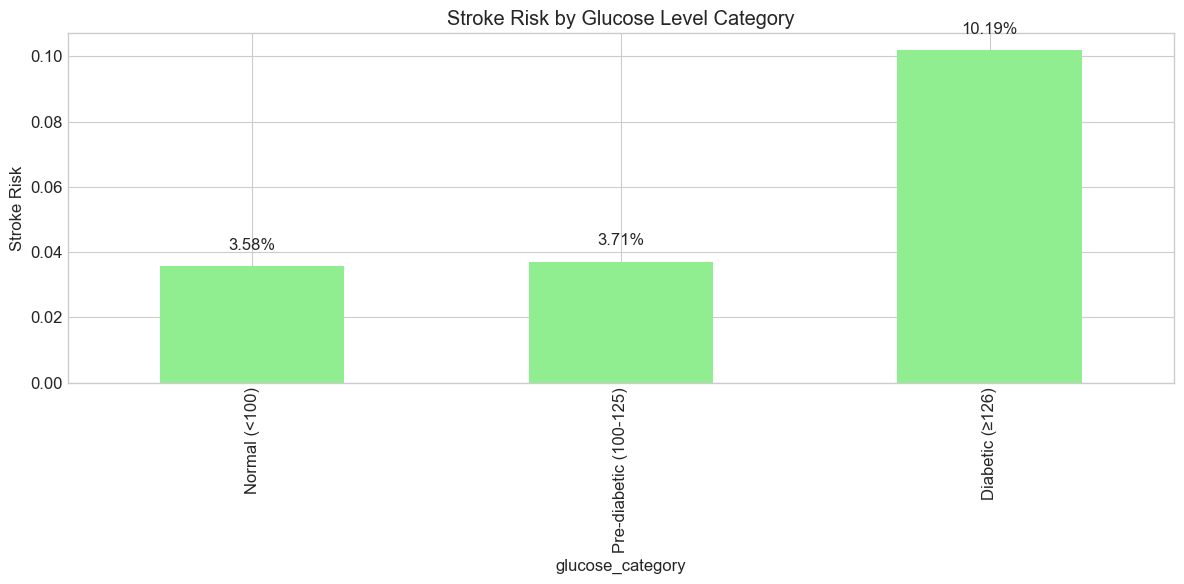


4. BMI Risk Analysis

Risk by BMI Category:
Underweight (<18.5): 0.29% (1 strokes out of 349 patients)
Normal (18.5-24.9): 2.94% (37 strokes out of 1258 patients)
Overweight (25-29.9): 5.32% (75 strokes out of 1409 patients)
Obese (≥30): 5.07% (96 strokes out of 1893 patients)


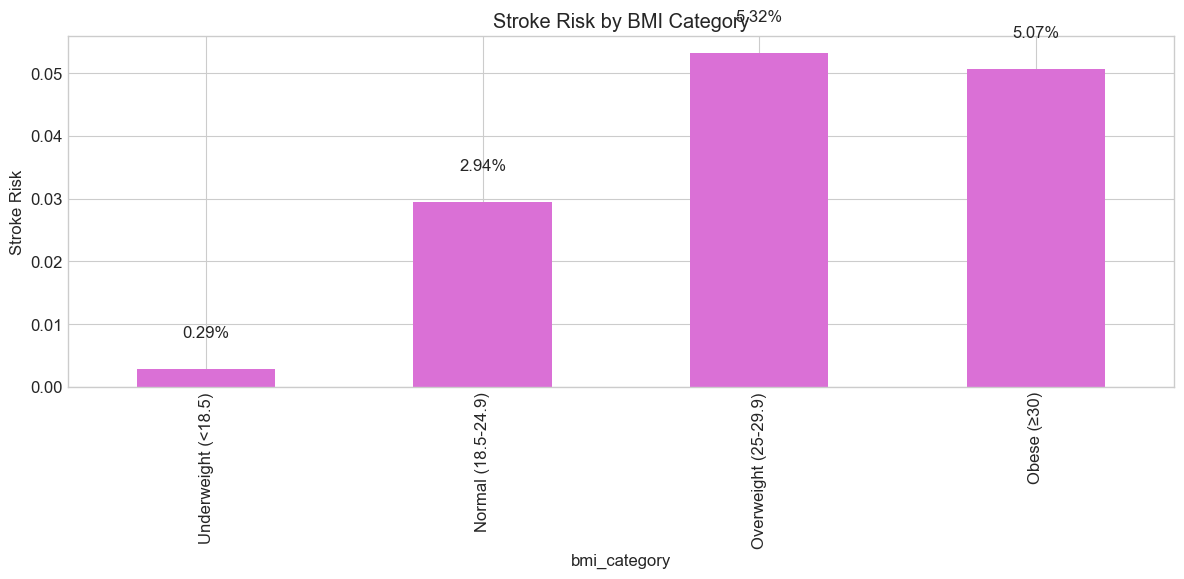

INTERACTION ANALYSIS - STROKE DATASET

1. Age and Hypertension Interaction

Stroke Risk by Age Group and Hypertension Status:


hypertension,0,1
age_group,,
<40,0.003179,0.023810
40-60,0.036744,0.074713
>60,0.122309,0.184397



Risk Ratios (Hypertension vs No Hypertension):


age_group
<40      7.489796
40-60    2.033356
>60      1.507631
dtype: float64

<Figure size 1200x600 with 0 Axes>

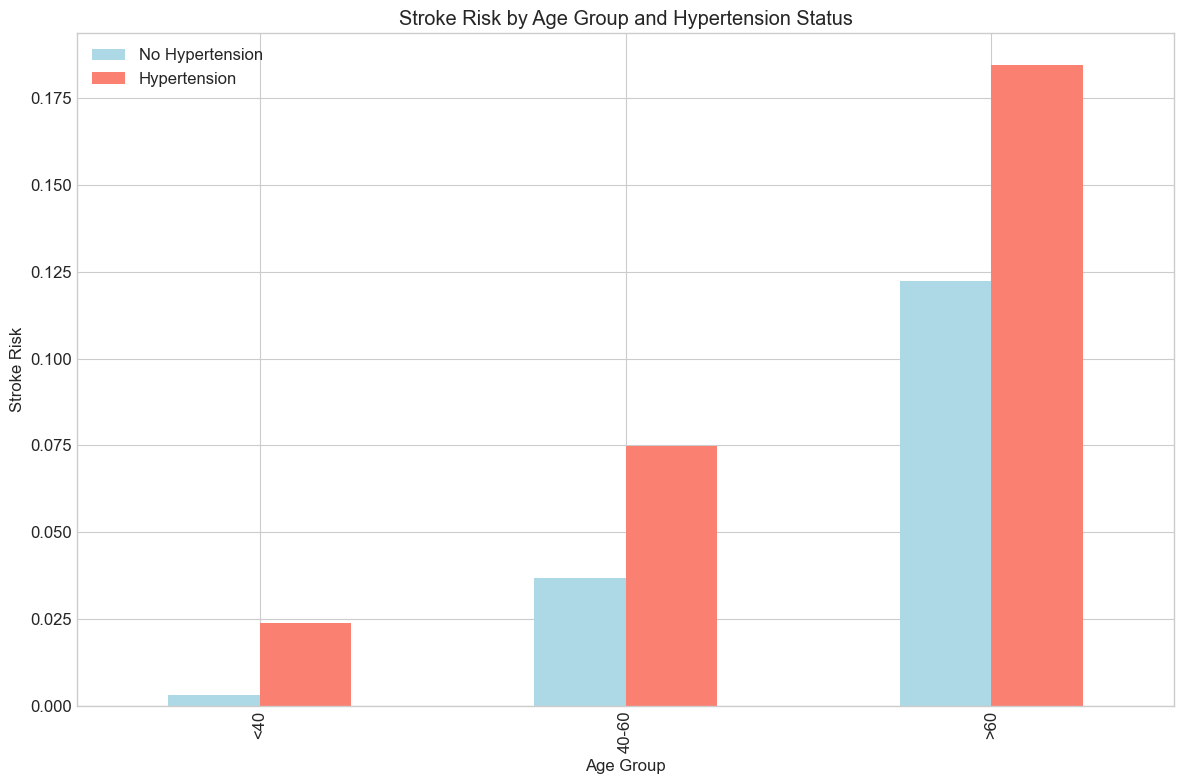


2. Age and Heart Disease Interaction

Stroke Risk by Age Group and Heart Disease Status:


heart_disease,0,1
age_group,,
<40,0.00357,0.000000
40-60,0.03936,0.079365
>60,0.12340,0.200000



Risk Ratios (Heart Disease vs No Heart Disease):


age_group
<40      0.000000
40-60    2.016411
>60      1.620741
dtype: float64

<Figure size 1200x600 with 0 Axes>

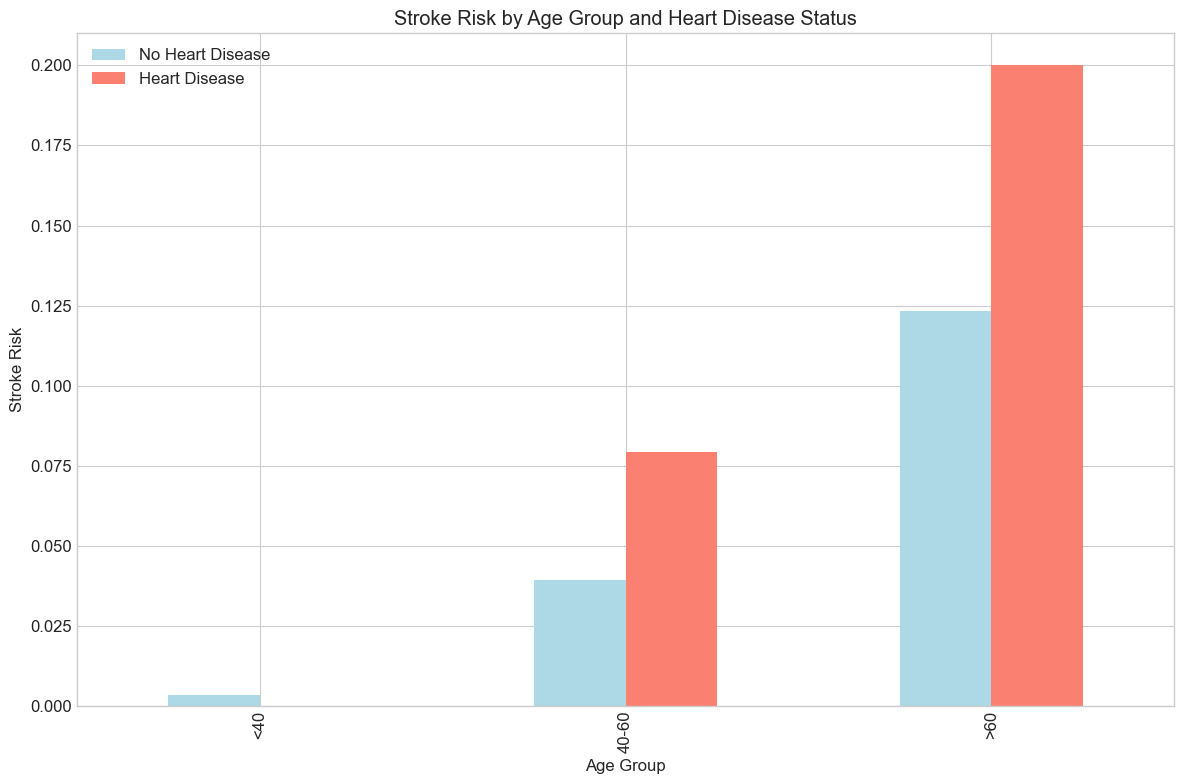


3. Age and Glucose Level Interaction

Stroke Risk by Age Group and Glucose Category:


glucose_category,Normal (<100),Pre-diabetic (100-125),Diabetic (≥126)
age_group,,,
<40,0.004660,0.002045,0.000000
40-60,0.034335,0.032258,0.068750
>60,0.104735,0.130653,0.191176


<Figure size 1400x700 with 0 Axes>

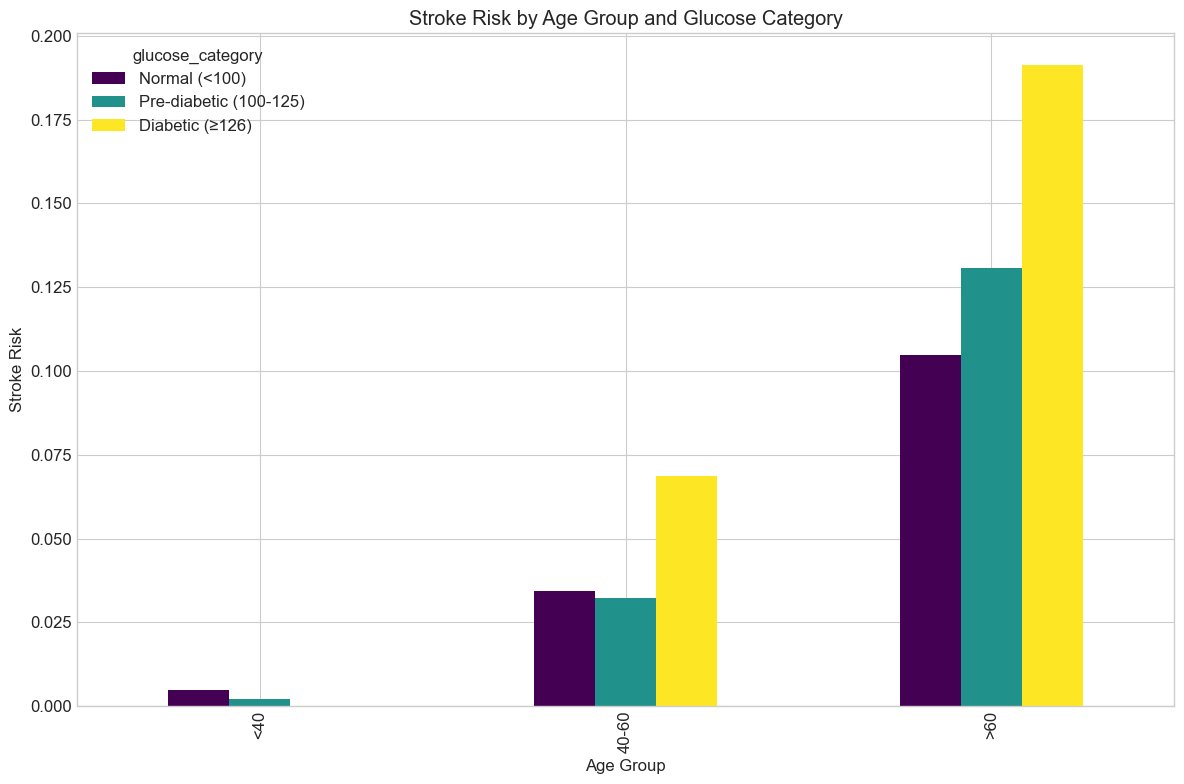


4. Combined Effect of Hypertension and Heart Disease

Stroke Risk by Age Group and Combined Medical Conditions:


risk_category,Both Conditions,No Conditions,One Condition
age_group,,,
<40,NaN,0.003183,0.022222
40-60,0.090909,0.035180,0.074419
>60,0.226415,0.109827,0.181347


<Figure size 1400x700 with 0 Axes>

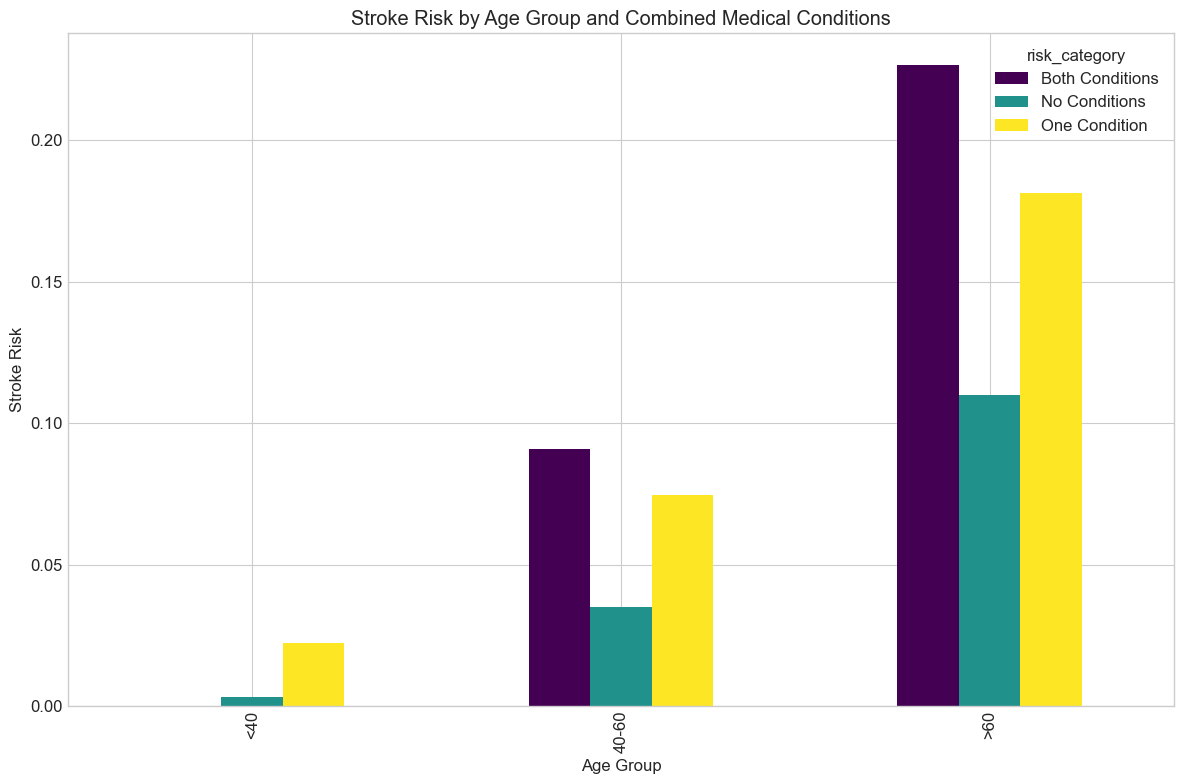


5. Statistical Test for Interaction Effects

ANOVA for Age and Hypertension Interaction:


,sum_sq,df,F,PR(>F)
C(age_group),11.670443,2.0,134.623585,1.055985e-57
C(hypertension),1.002600,1.0,23.130839,1.556962e-06
C(age_group):C(hypertension),0.089842,2.0,1.036363,3.548170e-01
Residual,221.231452,5104.0,NaN,NaN



ANOVA for Age and Heart Disease Interaction:


,sum_sq,df,F,PR(>F)
C(age_group),11.286867,2.0,130.221289,6.938050e-56
C(heart_disease),1.055426,1.0,24.353780,8.271847e-07
C(age_group):C(heart_disease),0.075116,2.0,0.866644,4.204220e-01
Residual,221.193352,5104.0,NaN,NaN


MISSING DATA ANALYSIS - STROKE DATASET

Missing Values Summary:


,Missing Count,Missing Percent
id,0,0.000000
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
bmi,201,3.933464



Analysis of BMI Missing Values:

Stroke Rates by BMI Missingness:


,stroke
bmi_missing,
0,0.042575
1,0.199005



Age Statistics by BMI Missingness:


,BMI Present,BMI Missing
Mean Age,42.865374,52.049154
Median Age,44.000000,58.000000



T-test for Age Difference: t=-5.7260, p-value=0.00000003
Conclusion: Significant difference in age between records with and without BMI



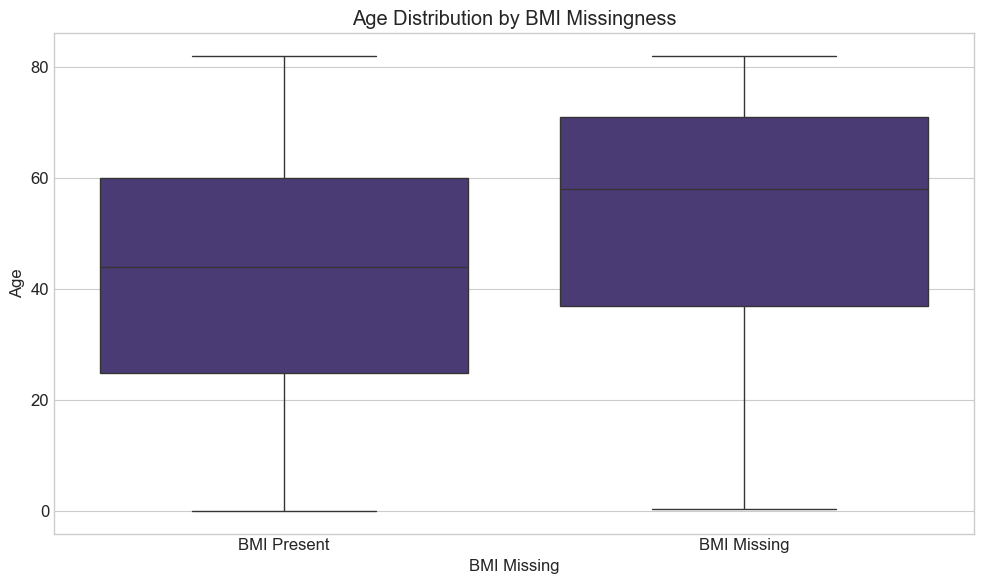


Chi-square tests for categorical variables vs BMI missingness:
gender: Chi2=9.2704, p-value=0.00970419, Significant: True
hypertension: Chi2=42.6409, p-value=0.00000000, Significant: True
heart_disease: Chi2=47.4808, p-value=0.00000000, Significant: True
ever_married: Chi2=6.3337, p-value=0.01184647, Significant: True
work_type: Chi2=10.1329, p-value=0.03824729, Significant: True
Residence_type: Chi2=0.2377, p-value=0.62584178, Significant: False
smoking_status: Chi2=36.5172, p-value=0.00000006, Significant: True
stroke: Chi2=98.5888, p-value=0.00000000, Significant: True

Potential BMI Imputation Methods:
1. Mean Imputation: 28.89
2. Median Imputation: 28.10

3. Group-based Imputation (medians):


,gender,age_group,bmi
0,Female,<40,25.1
1,Female,40-60,29.8
2,Female,>60,29.1
3,Male,<40,24.4
4,Male,40-60,30.9
5,Male,>60,29.1
6,Other,<40,22.4
7,Other,40-60,NaN
8,Other,>60,NaN



4. Machine Learning Imputation:
   - Recommended for this dataset due to observed patterns
   - Should include age, gender, and other relevant features as predictors
   - KNN or Random Forest imputation likely to perform well
RISK PROFILE ANALYSIS - STROKE DATASET

Risk Profile Definitions:
1. Low Risk: Age <50, no hypertension, no heart disease
2. Moderate Risk: Age 50-70 without conditions OR Age <50 with conditions
3. High Risk: Age >70 OR Age 50-70 with conditions

Risk by Profile:
High Risk: 16.29% (168 strokes out of 1031 patients)
Low Risk: 0.70% (20 strokes out of 2871 patients)
Moderate Risk: 5.05% (61 strokes out of 1208 patients)

Percentage of Population by Risk Profile:
High Risk: 20.18%
Low Risk: 56.18%
Moderate Risk: 23.64%

Risk Ratios (reference: Low Risk):
High Risk: 23.39x
Low Risk: 1.00x
Moderate Risk: 7.25x


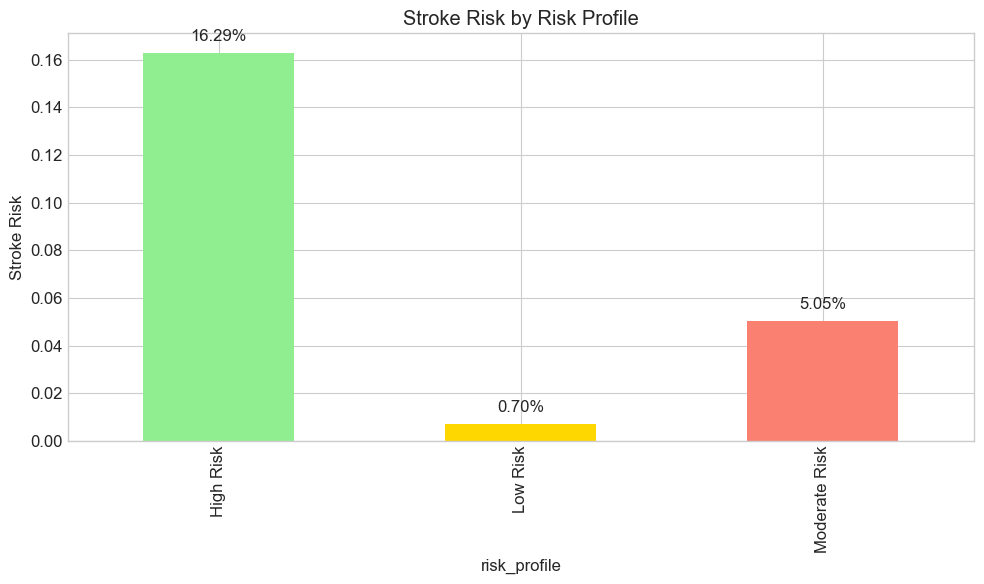

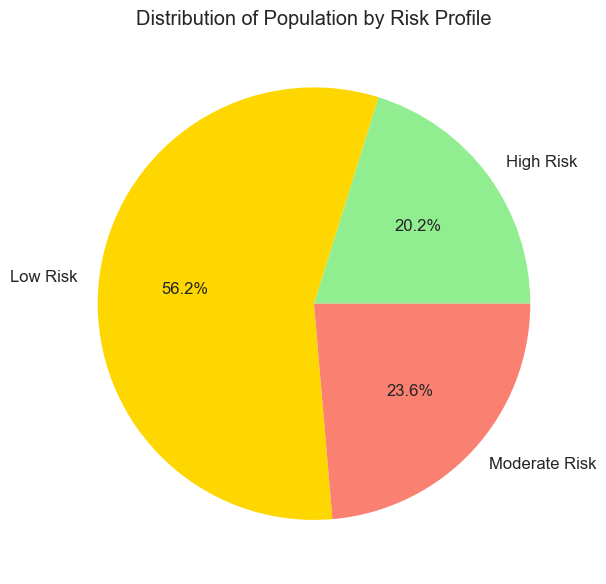

SMOKING AND WORK TYPE ANALYSIS - STROKE DATASET

1. Smoking Status Analysis

Risk by Smoking Status:
Unknown: 3.04% (47 strokes out of 1544 patients)
formerly smoked: 7.91% (70 strokes out of 885 patients)
never smoked: 4.76% (90 strokes out of 1892 patients)
smokes: 5.32% (42 strokes out of 789 patients)

Risk Ratios (reference: never smoked):
Unknown: 0.64x
formerly smoked: 1.66x
never smoked: 1.00x
smokes: 1.12x


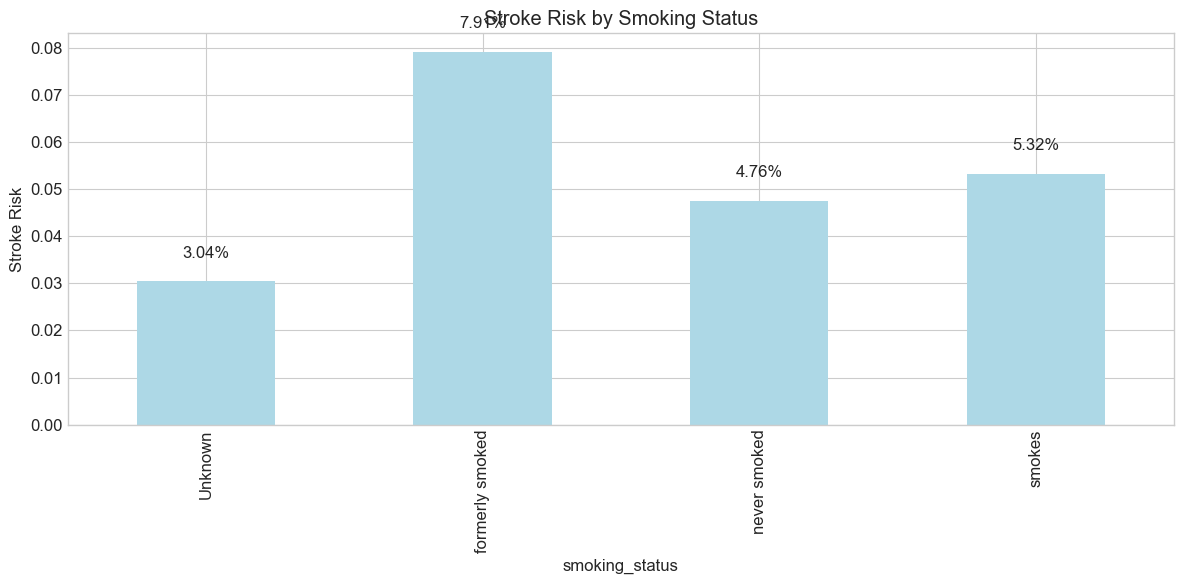


Mean Age by Smoking Status:


smoking_status
Unknown            30.229922
formerly smoked    54.929944
never smoked       46.744715
smokes             47.096324
Name: age, dtype: float64


2. Work Type Analysis

Risk by Work Type:
Govt_job: 5.02% (33 strokes out of 657 patients)
Never_worked: 0.00% (0 strokes out of 22 patients)
Private: 5.09% (149 strokes out of 2925 patients)
Self-employed: 7.94% (65 strokes out of 819 patients)
children: 0.29% (2 strokes out of 687 patients)

Risk Ratios (reference: children):
Govt_job: 17.25x
Never_worked: 0.00x
Private: 17.50x
Self-employed: 27.26x
children: 1.00x


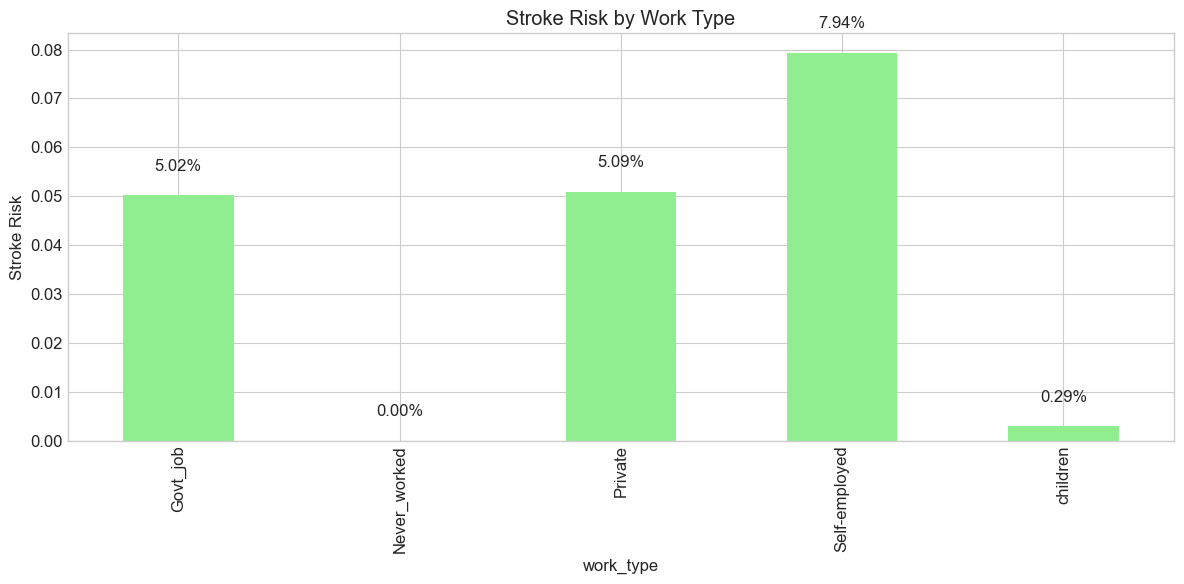


Mean Age by Work Type:


work_type
Govt_job         50.879756
Never_worked     16.181818
Private          45.503932
Self-employed    60.201465
children          6.841339
Name: age, dtype: float64

SUMMARY OF KEY FINDINGS - STROKE DATASET

1. Top Risk Factors for Stroke (by Risk Ratio)

1. Age >60 (vs <40)
   Risk Ratio: 38.07x
   Absolute Risk: 13.57%

2. Heart Disease
   Risk Ratio: 4.08x
   Absolute Risk: 17.03%

3. Hypertension
   Risk Ratio: 3.34x
   Absolute Risk: 13.25%

4. Diabetic Glucose Levels
   Risk Ratio: 2.85x
   Absolute Risk: 10.19%



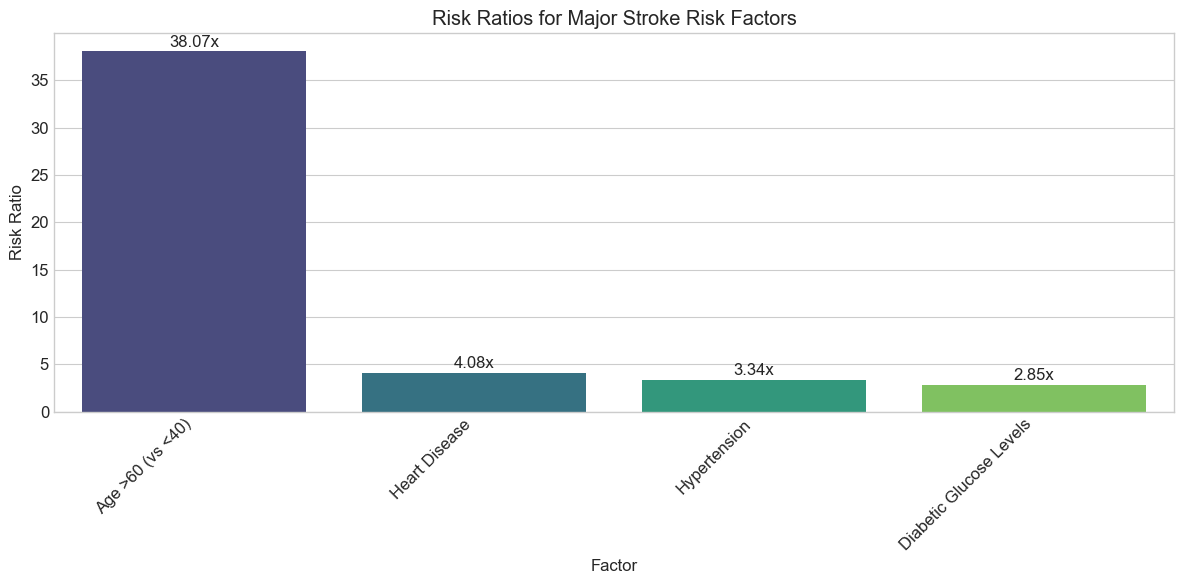

2. Risk Profile Analysis

Population Distribution and Stroke Risk by Risk Profile:
High Risk:
   Population: 20.18%
   Stroke Risk: 16.29%

Low Risk:
   Population: 56.18%
   Stroke Risk: 0.70%

Moderate Risk:
   Population: 23.64%
   Stroke Risk: 5.05%

3. Key Interaction Effects

Age and Hypertension Interaction:


hypertension,0,1
age_group,,
<40,0.003179,0.023810
40-60,0.036744,0.074713
>60,0.122309,0.184397



Age and Heart Disease Interaction:


heart_disease,0,1
age_group,,
<40,0.00357,0.000000
40-60,0.03936,0.079365
>60,0.12340,0.200000



4. Missing Data Patterns

Variables with Missing Data:
bmi: 201 values (3.93%)
bmi_category: 201 values (3.93%)

5. Recommendations for Modeling

Based on the statistical analysis, the following recommendations are made for modeling:

a) Feature Engineering:
   - Create age group categories (<40, 40-60, >60) as they show non-linear risk patterns
   - Create glucose level categories (normal, pre-diabetic, diabetic)
   - Consider interaction terms between age and medical conditions
   - Create a combined risk score based on age and medical conditions

b) Missing Data Handling:
   - Use machine learning imputation for BMI, including age and gender as predictors
   - Consider MICE (Multiple Imputation by Chained Equations) or KNN imputation

c) Class Imbalance Handling:
   - Apply SMOTE or ADASYN for oversampling the minority class
   - Consider stratified sampling during cross-validation
   - Use appropriate evaluation metrics (F1-score, AUPRC) instead of accuracy

d) Model Selection:
  

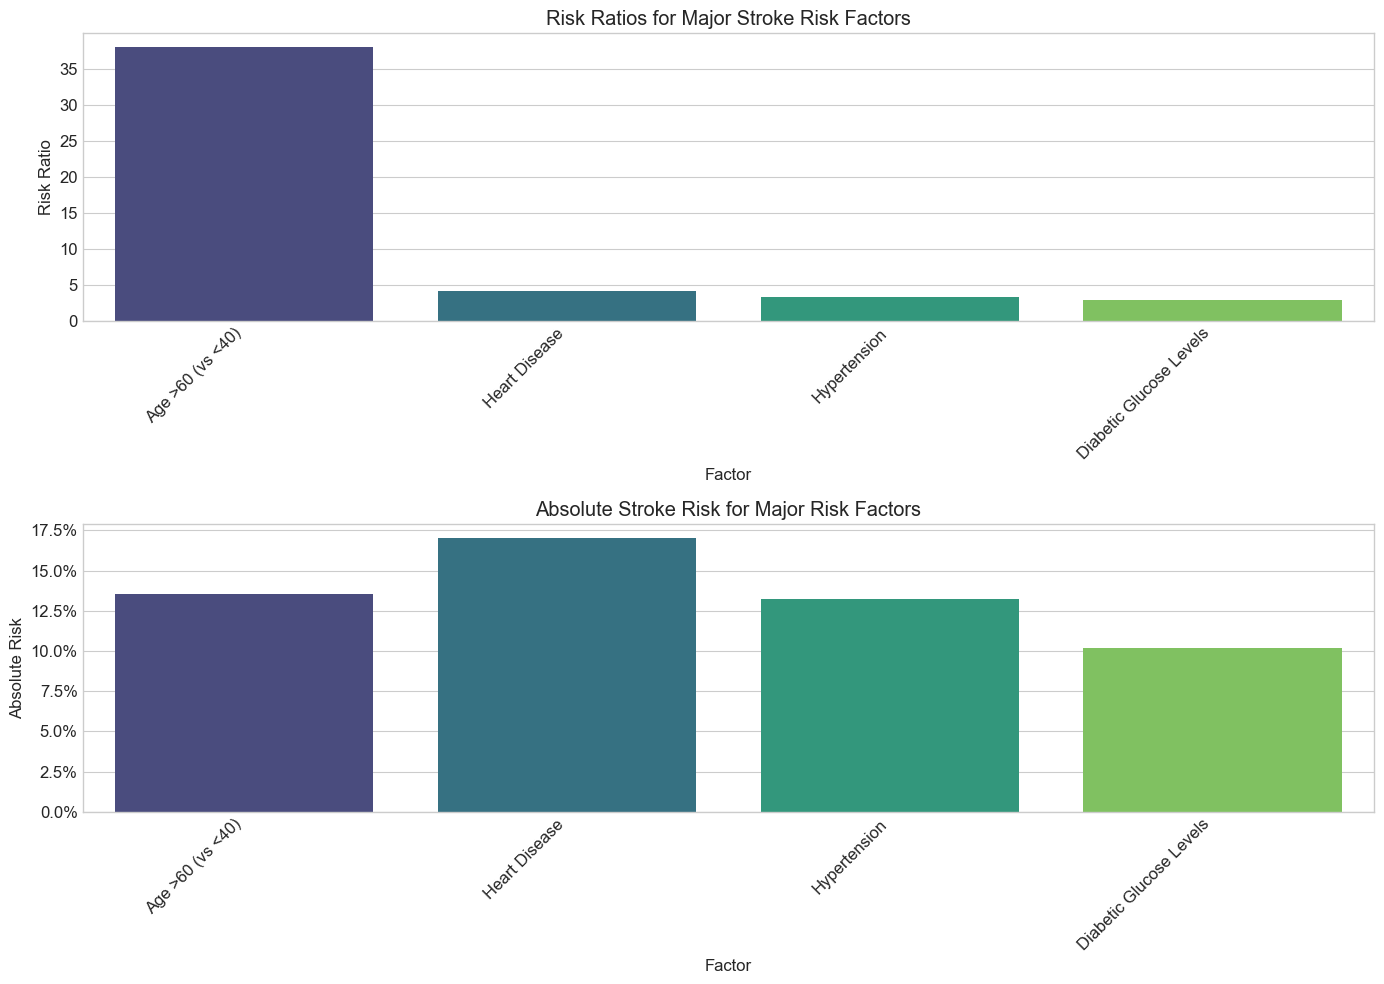


All analyses completed successfully.
Results displayed inline in the notebook.


In [14]:
def main():
    # Load data
    df = load_data('C://Users//Nikhil//Desktop/Stroke Prediction//healthcare-dataset-stroke-data.csv')
    
    # Run all analyses
    descriptive_statistics(df)
    normality_tests(df)
    correlation_analysis(df)
    hypothesis_testing(df)
    df = risk_analysis(df)  # Returns df with added categories
    interaction_analysis(df)
    missing_data_analysis(df)
    risk_profile_analysis(df)
    smoking_work_analysis(df)
    summary_analysis(df)
    
    print("\nAll analyses completed successfully.")
    print("Results displayed inline in the notebook.")

# Execute the main function (optional - you can also call functions individually)
if __name__ == "__main__":
    main()